In [ ]:
! pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 9.7 MB/s eta 0:00:00


In [ ]:
import ray
import time
import numpy as np
import autograd
import autograd.numpy as anp
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

In [ ]:
def RandK(k, x):
    '''
    Parameters:
    k           : The percentage of coordinates sent
    x           : A numpy array to be compressed

    Returns:
    x_compressed: A numpy array that has been compressed
    mask        : Compressor mask showing coordinates transmitted
    '''
    assert k <= 100
    assert k > 0

    d = len(x)
    k = int(d*k/100)
    C_i = np.zeros(d)
    C_i[:k] =  1
    np.random.shuffle(C_i)
    mask = C_i > 0
    x_compressed = (d/k) * C_i * x
    return x_compressed, mask

def PermK(d, n):
    '''
    Parameters:
    d         : The dimension of the vector to be compressed
    n         : Number of workers

    Returns:
    cs        : A list of compressor vectors [c_1, c_2, ..., c_n]
                where c_k is for the kth worker.
    '''
    cs = []
    if d >= n:
        q = d//n
        perm_list = np.random.permutation(d)
        temp_q = 0
        for i in range(n):
            c_i = [0 for _ in range(d)] # The compressor for the ith worker
            for j in range(q): # Take q coordinates for compressor i
                c_i[perm_list[temp_q]] = n
                temp_q += 1
            cs.append(np.array(c_i))
        return cs
    else: # d < n
        q = n//d
        s = [i for i in range(d) for _ in range(q)] # Multiset as described in paper
        perm_s = np.random.permutation(s)
        for i in range(n):
            c_i = [0 for _ in range(d)]
            c_i[perm_s[i]] = d
            cs.append(np.array(c_i))
        return cs

In [ ]:
PermK(6, 3), PermK(3, 6)

([array([3, 0, 0, 3, 0, 0]),
  array([0, 0, 3, 0, 0, 3]),
  array([0, 3, 0, 0, 3, 0])],
 [array([0, 3, 0]),
  array([0, 3, 0]),
  array([0, 0, 3]),
  array([0, 0, 3]),
  array([3, 0, 0]),
  array([3, 0, 0])])

Using the Logistic Regression Classifier on mushrooms dataset and Marina, CGD.

Consider the empirical risk minimization problem:

\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}
where $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ is a loss function, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ is a model, $w$ are parameters of the model, $\{x_i, y_i\}_{i=1}^n$ is data of objects $x_i \in \mathbb{R}^x$ and labels $y_i \in \mathbb{R}$.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoid loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Important: $y$ must take values $-1$ or $1$__). As we already know, the resulting problem is called a logistic regression problem.

This problem can be rewritten as follows:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{s} \sum\limits_{j=1}^s f_j(w) := \frac{1}{s} \sum\limits_{j=1}^s \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_{(j-1)b + i}), y_{(j-1)b + i}) + \frac{\lambda}{2} \| w\|^2_2\right],
\end{equation}
where $b$ is the local data size, $s$ is the number of devices, and $b s = n$ is the total sample size.

The gradient of $f_j$:
$$
\nabla f_j(w) = \frac{1}{b} \sum_{i=1}^b \frac{-y_{(j-1)b + i} x_{(j-1)b + i}}{1 + \exp(y_{(j-1)b + i} w^Tx_{(j-1)b + i})} + \lambda w.
$$
The Lipschitz constant of the gradient $\nabla f_j$ can be estimated as $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2 + \lambda$.

In [ ]:
dataset = '/content/mushrooms.txt'

from sklearn.datasets import load_svmlight_file

data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2 * y - 3

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
data[1]

array([1., 2., 2., ..., 2., 1., 2.])

In [ ]:
L = np.trace(X_train.T @ X_train)/(4*X_train.shape[0])
regularizer = L/10

def cost(w, x, y, regularizer = regularizer):
    '''
    Evaluates the cost function

    Parameters
    w:           autograd.numpy array containing weights of the model
    x:           autograd.numpy array containing features of the data point
    y:           autograd.numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    loss: the value of the cost function of a data batch for a given set of weights
    '''
    n = len(y)
    loss = 0
    g = (x @ w).flatten()
    y = y.flatten()
    for i in range(n):
        l = anp.log(1 + anp.exp(-y[i]*g[i]))
        loss += l
    loss /= n
    loss += regularizer * anp.sum(w.T @ w)
    return loss


In [ ]:
@ray.remote
def worker(w, gamma, batch, cost):
    '''
    w      : Gradient from Server
    gamma  : Learning rate
    batch  : Data available to worker
    f      : Target function to optimize (callable)

    Returns:
    grad   : Local Gradient Value
    '''
    f = lambda w: cost(w, batch[0], batch[1])
    grad_ = autograd.grad(f)(w)
    return grad_

def split_data(b: int, data: tuple[np.array]) -> tuple:
    '''
    Parameters:
    b   : Batchsizes of each data
    data: Tuple of numpy arrays

    Returns:
    out : tuple of tuples of numpy arrays
    '''
    out = []
    for i in range(0, len(data[1]), b):
        out.append((data[0][i: i+b], data[1][i: i+b]))
    return tuple(out)

def predict(w, x):
    '''
    Predicts the class, given a set of weights and features

    Parameters
    w:           numpy array containing weights of the model
    x:           numpy array containing features of the data point

    Returns:
    y_pred: numpy array of predicted labels
    '''
    g = (x @ w).flatten()
    y_pred = (g >= 0) + (g < 0)*-1
    return y_pred.flatten()

def Marina_RandK(w_0, data, gamma, f, k, p = 0.5, num_workers = 10,
        iterations = 100, eps = 1e-8):
    '''

    Parameters
    w_0        :   Start point
    data       :   Data to train the algorithm on
    gamma      :   Learning rate
    f          :   Target function
    k          :   Percent compression for Rand_K compressor
    p          :   Parameter for Bernoulli distribution
    num_workers:   Number of independent batches to split the data into
    iterations :   Number if iterations
    eps        :   Accuracy

    Return
    w_opt   :   Optimal point found by the algorithm
    path    :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]/norm(w_0)
    testacc :   Prediction accuracy per iteration on test set
    trainacc:   Prediction accuracy per iteration on train set
    '''
    start = time.time()
    b = len(data[0])//num_workers
    batches = split_data(b, data)
    # To have the number of parts equal to the number of workers
    batches = tuple(list(batches[:num_workers]))
    obj_ref = [worker.remote(w_0, gamma, batch, f) for batch in batches]
    obj = ray.get(obj_ref)
    g = np.array(sum(obj))/num_workers
    norm_w_0 = np.linalg.norm(g)
    path = []
    testacc = []
    trainacc = []
    w_prev = w_0
    for _ in tqdm(range(iterations)):
        w_new = w_prev - gamma * g
        g_new = np.zeros_like(w_prev)
        w_prevs = obj
        obj_ref = [worker.remote(w_new, gamma, batch, f) for batch in batches]
        obj = ray.get(obj_ref)
        for i in range(num_workers):
            bern = (random.uniform(0, 1) < p)
            if bern:
                g_new += obj[i]
            else:
                comp, _ = RandK(k, (obj[i] - w_prevs[i]))
                g_new += g + comp
        g_new /= num_workers
        g = g_new
        path.append(np.linalg.norm(w_new - w_prev)/norm_w_0)
        testacc.append(sum(predict(w_new, X_test) == y_test)/len(y_test))
        trainacc.append(sum(predict(w_new, X_train) == y_train)/len(y_train))
        if np.all(np.abs(w_new - w_prev) <= eps):
            break
        w_prev = w_new
    w_opt = w_new
    end = time.time()
    print(f'Marina with RandK compressor with {num_workers} workers, took {end - start} seconds')
    return w_opt, path, testacc, trainacc

 22%|██▏       | 22/100 [00:28<01:40,  1.28s/it]


Marina with RandK compressor with 10 workers, took 29.27496647834778 seconds


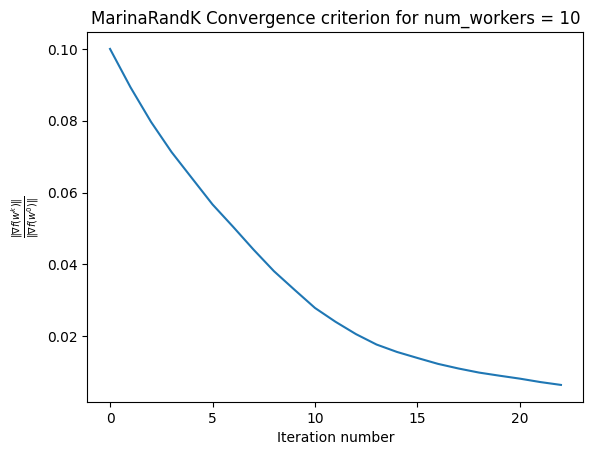

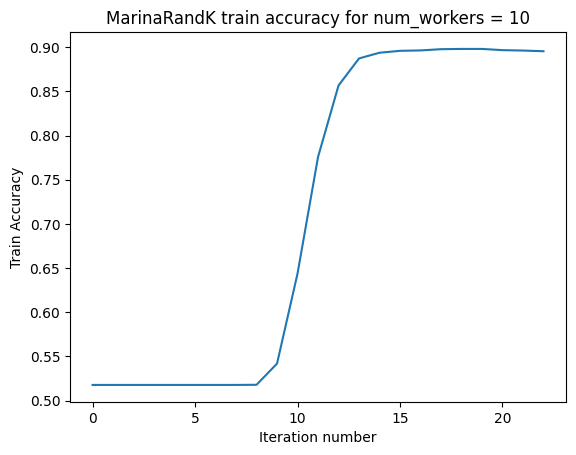

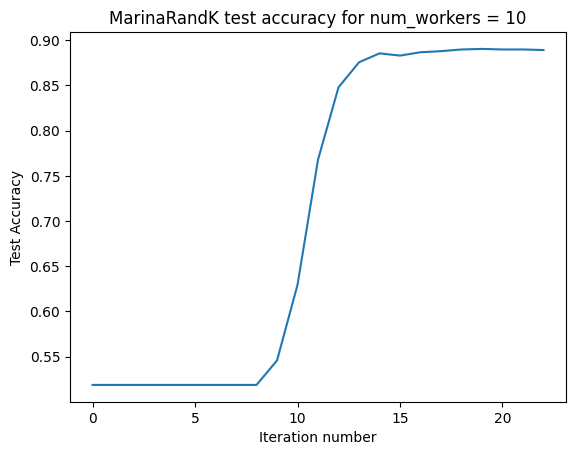

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 10
w_opt, path, testacc, trainacc = Marina_RandK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost, k = 30,
                                              p = 0.2, num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord = [i for i in range(len(path))]
plt.plot(x_cord, path)
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'MarinaRandK Convergence criterion for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, trainacc)
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'MarinaRandK train accuracy for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, testacc)
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'MarinaRandK test accuracy for num_workers = {num_workers}')
plt.show()

In [ ]:
def Marina_PermK(w_0, data, gamma, f, p = 0.5, num_workers = 10,
        iterations = 100, eps = 1e-8):
    '''

    Parameters
    w_0        :   Start point
    data       :   Data to train the algorithm on
    gamma      :   Learning rate
    f          :   Target function
    p          :   Parameter for Bernoulli distribution
    num_workers:   Number of independent batches to split the data into
    iterations :   Number if iterations
    eps        :   Accuracy

    Return
    w_opt   :   Optimal point found by the algorithm
    path    :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]/norm(w_0)
    testacc :   Prediction accuracy per iteration on test set
    trainacc:   Prediction accuracy per iteration on train set
    '''
    start = time.time()
    b = len(data[0])//num_workers
    batches = split_data(b, data)
    # To have the number of parts equal to the number of workers
    batches = tuple(list(batches[:num_workers]))
    obj_ref = [worker.remote(w_0, gamma, batch, f) for batch in batches]
    obj = ray.get(obj_ref)
    g = np.array(sum(obj))/num_workers
    norm_w_0 = np.linalg.norm(g)
    path = []
    testacc = []
    trainacc = []
    w_prev = w_0
    d = len(w_0)
    n = num_workers
    for _ in tqdm(range(iterations)):
        w_new = w_prev - gamma * g
        g_new = np.zeros_like(w_prev)
        w_prevs = obj
        obj_ref = [worker.remote(w_new, gamma, batch, f) for batch in batches]
        obj = ray.get(obj_ref)
        cs = PermK(d, n)
        for i in range(num_workers):
            bern = (random.uniform(0, 1) < p)
            if bern:
                g_new += obj[i]
            else:
                comp = cs[i] * (obj[i] - w_prevs[i])
                g_new += g + comp
        g_new /= num_workers
        g = g_new
        path.append(np.linalg.norm(w_new - w_prev)/norm_w_0)
        testacc.append(sum(predict(w_new, X_test) == y_test)/len(y_test))
        trainacc.append(sum(predict(w_new, X_train) == y_train)/len(y_train))
        if np.all(np.abs(w_new - w_prev) <= eps):
            break
        w_prev = w_new
    w_opt = w_new
    end = time.time()
    print(f'Marina with PermK compressor with {num_workers} workers, took {end - start} seconds')
    return w_opt, path, testacc, trainacc

 22%|██▏       | 22/100 [00:28<01:42,  1.31s/it]


Marina with PermK compressor with 10 workers, took 29.975177526474 seconds


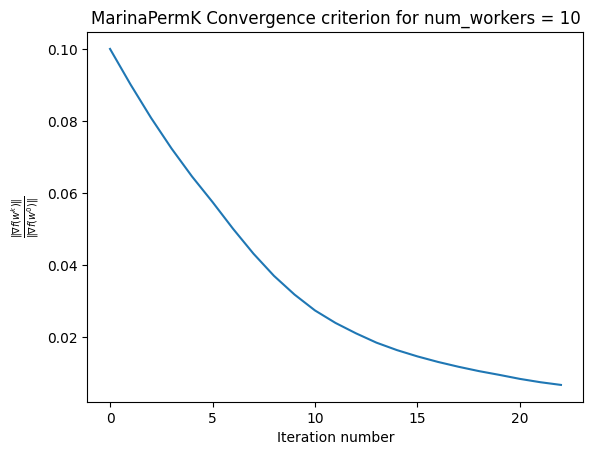

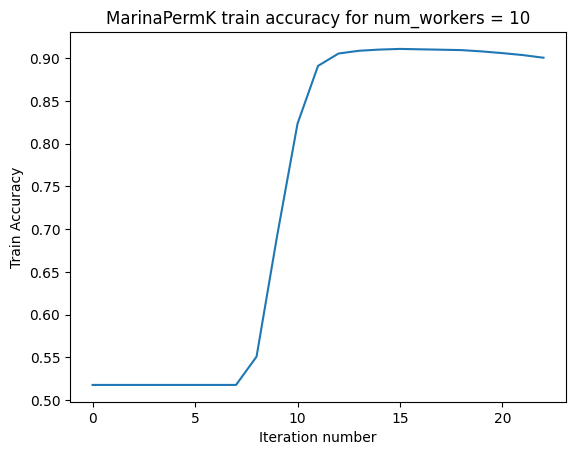

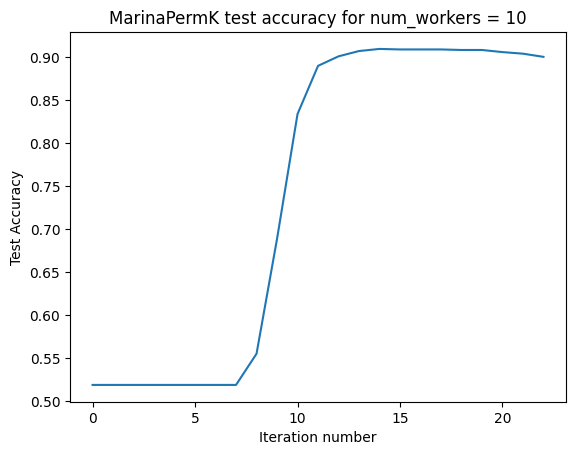

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 10
w_opt, path, testacc, trainacc = Marina_PermK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                              p = 0.2, num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord = [i for i in range(len(path))]
plt.plot(x_cord, path)
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'MarinaPermK Convergence criterion for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, trainacc)
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'MarinaPermK train accuracy for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, testacc)
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'MarinaPermK test accuracy for num_workers = {num_workers}')
plt.show()

 22%|██▏       | 22/100 [00:37<02:11,  1.69s/it]


Marina with RandK compressor with 10 workers, took 38.996012926101685 seconds


 22%|██▏       | 22/100 [00:26<01:35,  1.23s/it]


Marina with PermK compressor with 10 workers, took 28.290557622909546 seconds


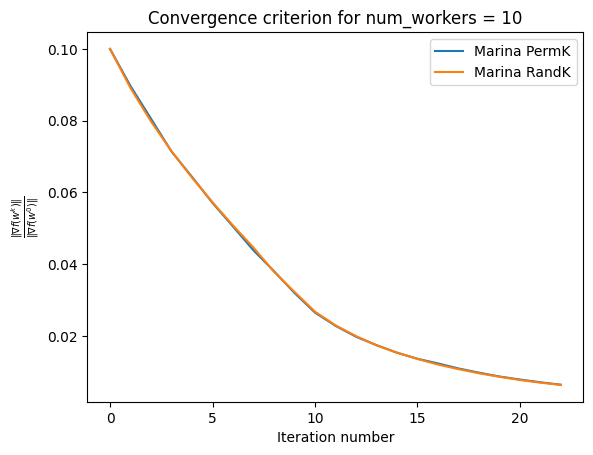

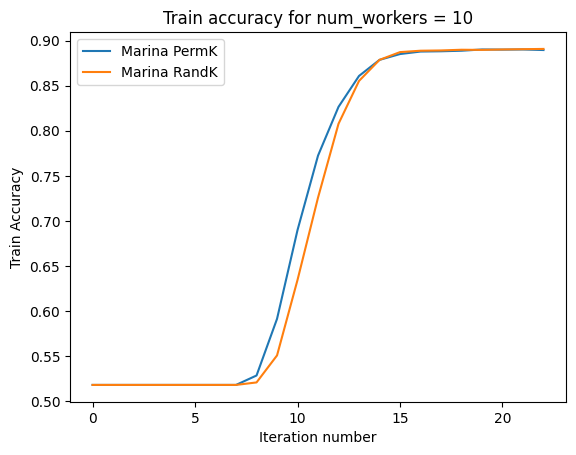

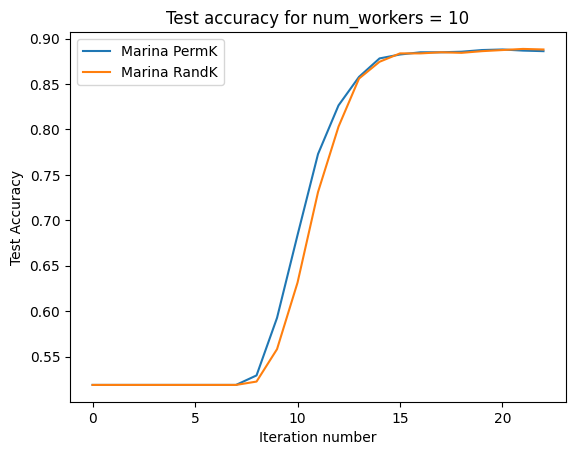

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 10

w_opt1, path1, testacc1, trainacc1 = Marina_RandK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost, k = 30,
                                              p = 0.2, num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord1 = [i for i in range(len(path1))]

w_opt, path, testacc, trainacc = Marina_PermK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                              p = 0.2, num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord = [i for i in range(len(path))]
plt.plot(x_cord, path, label = 'Marina PermK')
plt.plot(x_cord1, path1, label = 'Marina RandK')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'Convergence criterion for num_workers = {num_workers}')
plt.legend()
plt.show()

plt.plot(x_cord, trainacc, label = 'Marina PermK')
plt.plot(x_cord1, trainacc1, label = 'Marina RandK')
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'Train accuracy for num_workers = {num_workers}')
plt.legend()
plt.show()

plt.plot(x_cord, testacc, label = 'Marina PermK')
plt.plot(x_cord1, testacc1, label = 'Marina RandK')
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'Test accuracy for num_workers = {num_workers}')
plt.legend()
plt.show()

 24%|██▍       | 24/100 [00:34<01:49,  1.45s/it]


Marina with RandK compressor with 20 workers, took 36.98721623420715 seconds


 22%|██▏       | 22/100 [00:30<01:47,  1.38s/it]


Marina with PermK compressor with 20 workers, took 31.58401846885681 seconds


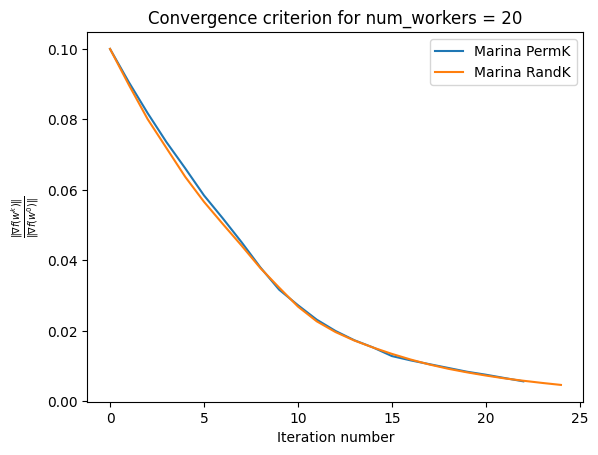

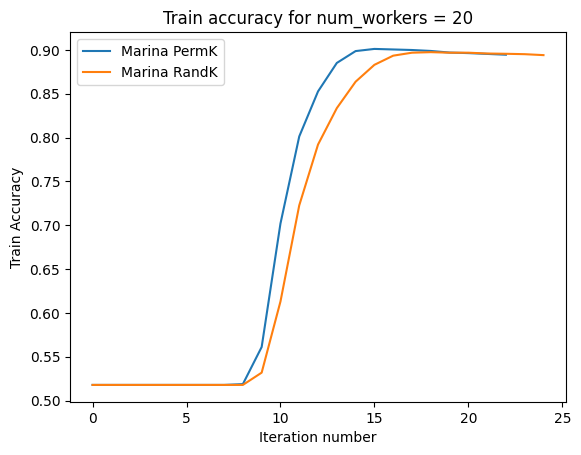

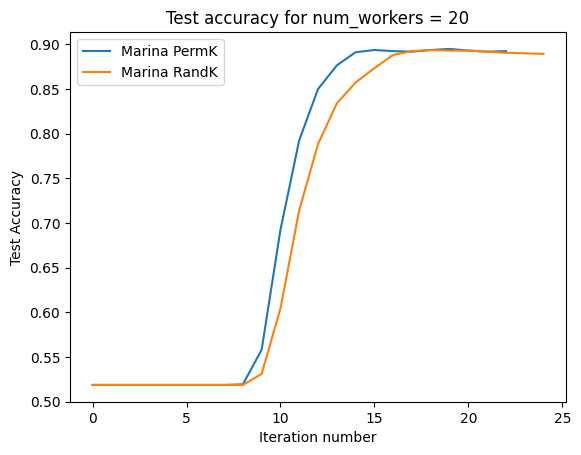

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 20

w_opt1, path1, testacc1, trainacc1 = Marina_RandK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost, k = 30,
                                              p = 0.2, num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord1 = [i for i in range(len(path1))]

w_opt, path, testacc, trainacc = Marina_PermK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                              p = 0.2, num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord = [i for i in range(len(path))]
plt.plot(x_cord, path, label = 'Marina PermK')
plt.plot(x_cord1, path1, label = 'Marina RandK')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'Convergence criterion for num_workers = {num_workers}')
plt.legend()
plt.show()

plt.plot(x_cord, trainacc, label = 'Marina PermK')
plt.plot(x_cord1, trainacc1, label = 'Marina RandK')
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'Train accuracy for num_workers = {num_workers}')
plt.legend()
plt.show()

plt.plot(x_cord, testacc, label = 'Marina PermK')
plt.plot(x_cord1, testacc1, label = 'Marina RandK')
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'Test accuracy for num_workers = {num_workers}')
plt.legend()
plt.show()

 21%|██        | 21/100 [00:34<02:09,  1.63s/it]


Marina with RandK compressor with 50 workers, took 35.611793518066406 seconds


 22%|██▏       | 22/100 [00:36<02:08,  1.65s/it]


Marina with PermK compressor with 50 workers, took 37.70052742958069 seconds


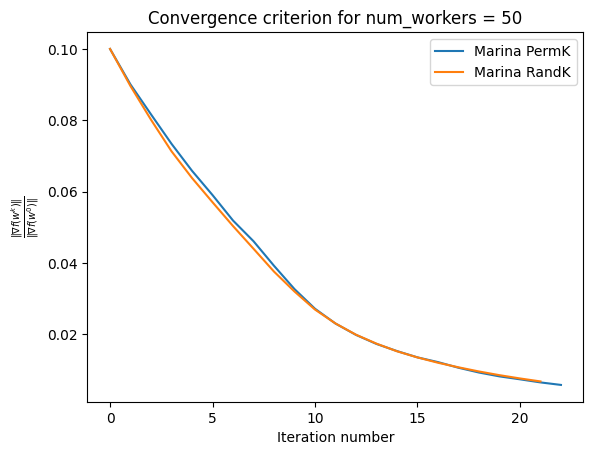

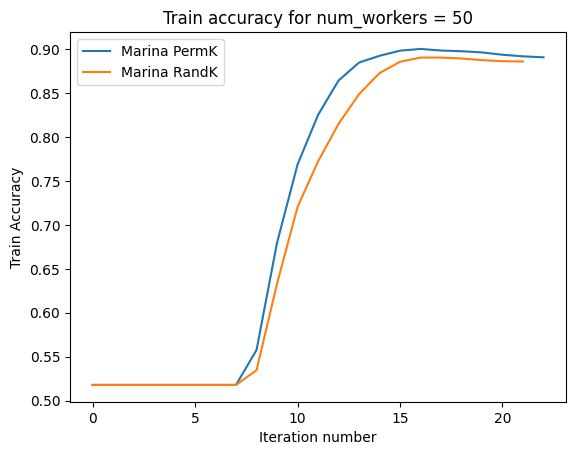

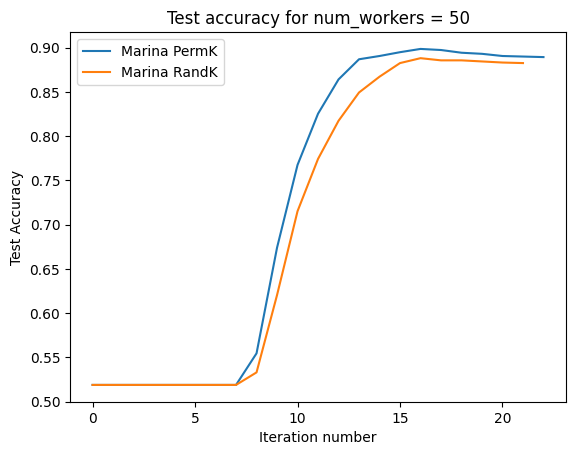

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 50

w_opt1, path1, testacc1, trainacc1 = Marina_RandK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost, k = 30,
                                              p = 0.2, num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord1 = [i for i in range(len(path1))]

w_opt, path, testacc, trainacc = Marina_PermK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                              p = 0.2, num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord = [i for i in range(len(path))]
plt.plot(x_cord, path, label = 'Marina PermK')
plt.plot(x_cord1, path1, label = 'Marina RandK')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'Convergence criterion for num_workers = {num_workers}')
plt.legend()
plt.show()

plt.plot(x_cord, trainacc, label = 'Marina PermK')
plt.plot(x_cord1, trainacc1, label = 'Marina RandK')
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'Train accuracy for num_workers = {num_workers}')
plt.legend()
plt.show()

plt.plot(x_cord, testacc, label = 'Marina PermK')
plt.plot(x_cord1, testacc1, label = 'Marina RandK')
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'Test accuracy for num_workers = {num_workers}')
plt.legend()
plt.show()

 22%|██▏       | 22/100 [00:26<01:35,  1.22s/it]


Marina with RandK compressor with 10 workers, took 27.85293745994568 seconds


 22%|██▏       | 22/100 [00:26<01:34,  1.22s/it]


Marina with PermK compressor with 10 workers, took 28.426061630249023 seconds


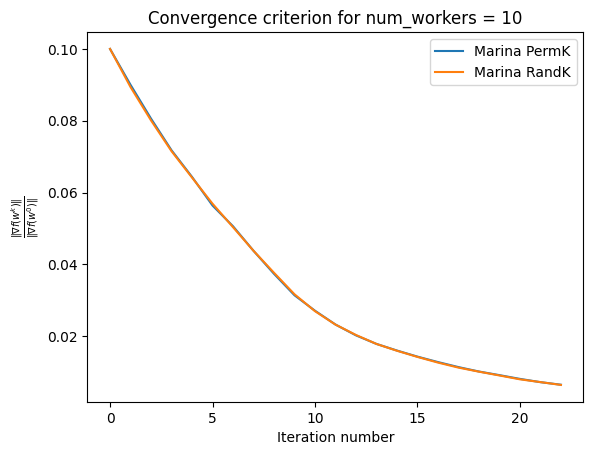

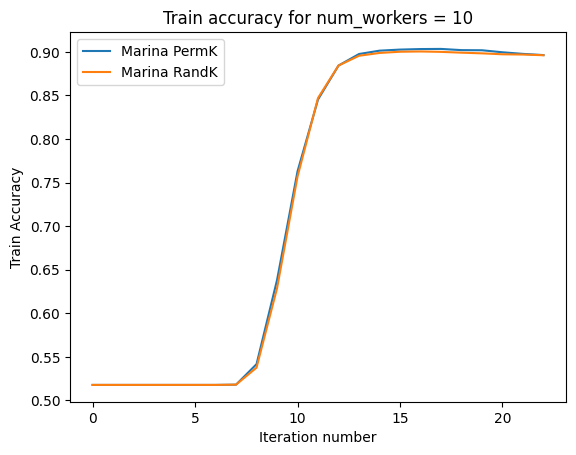

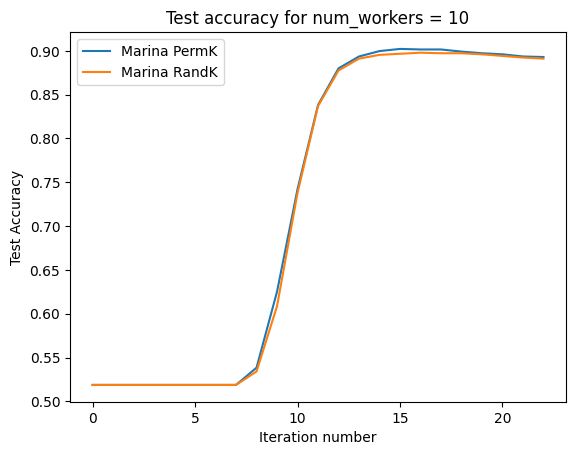

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 10

w_opt1, path1, testacc1, trainacc1 = Marina_RandK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost, k = 30,
                                              p = 0.5, num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord1 = [i for i in range(len(path1))]

w_opt, path, testacc, trainacc = Marina_PermK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                              p = 0.5, num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord = [i for i in range(len(path))]
plt.plot(x_cord, path, label = 'Marina PermK')
plt.plot(x_cord1, path1, label = 'Marina RandK')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'Convergence criterion for num_workers = {num_workers}')
plt.legend()
plt.show()

plt.plot(x_cord, trainacc, label = 'Marina PermK')
plt.plot(x_cord1, trainacc1, label = 'Marina RandK')
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'Train accuracy for num_workers = {num_workers}')
plt.legend()
plt.show()

plt.plot(x_cord, testacc, label = 'Marina PermK')
plt.plot(x_cord1, testacc1, label = 'Marina RandK')
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'Test accuracy for num_workers = {num_workers}')
plt.legend()
plt.show()

 25%|██▌       | 25/100 [00:31<01:35,  1.28s/it]


Marina with RandK compressor with 10 workers, took 33.74399542808533 seconds


 23%|██▎       | 23/100 [00:32<01:49,  1.42s/it]


Marina with PermK compressor with 10 workers, took 34.452168464660645 seconds


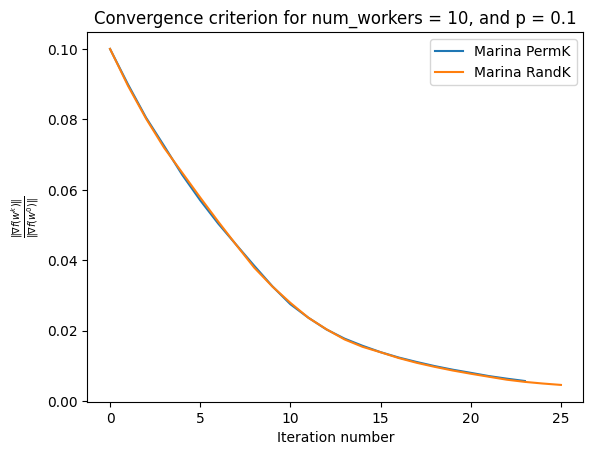

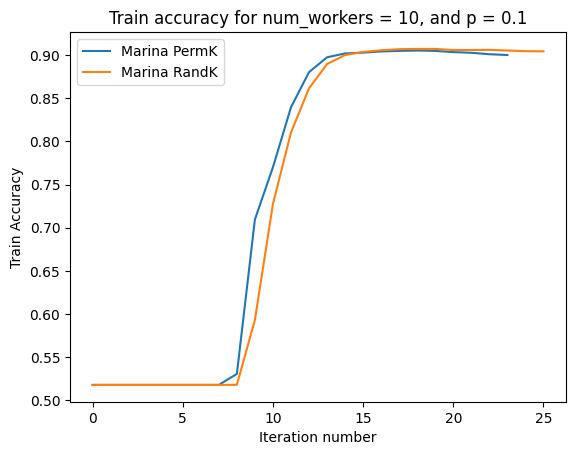

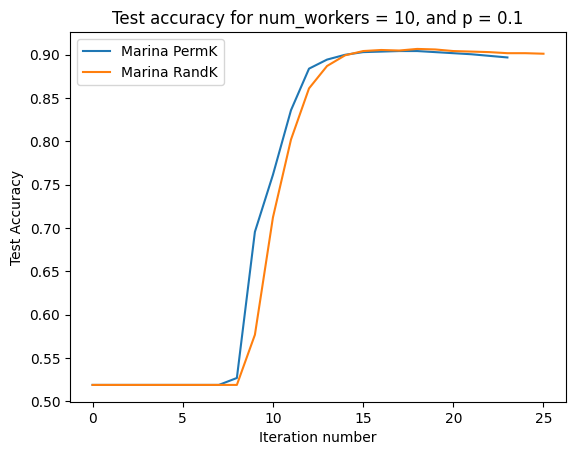

 22%|██▏       | 22/100 [00:31<01:52,  1.45s/it]


Marina with RandK compressor with 30 workers, took 33.03887963294983 seconds


 23%|██▎       | 23/100 [00:33<01:50,  1.44s/it]


Marina with PermK compressor with 30 workers, took 34.212525844573975 seconds


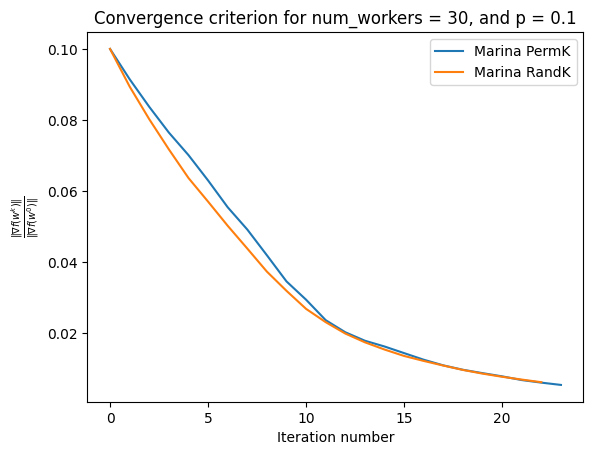

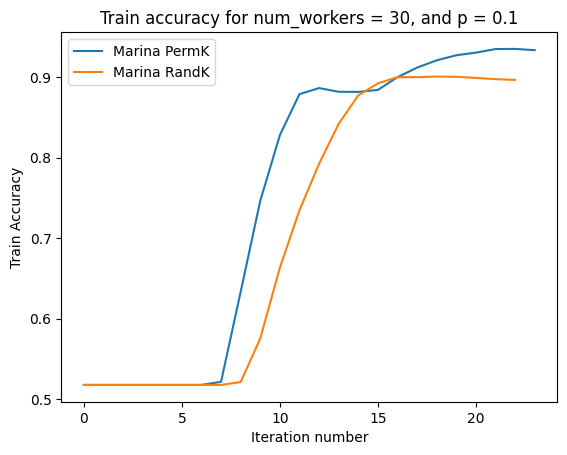

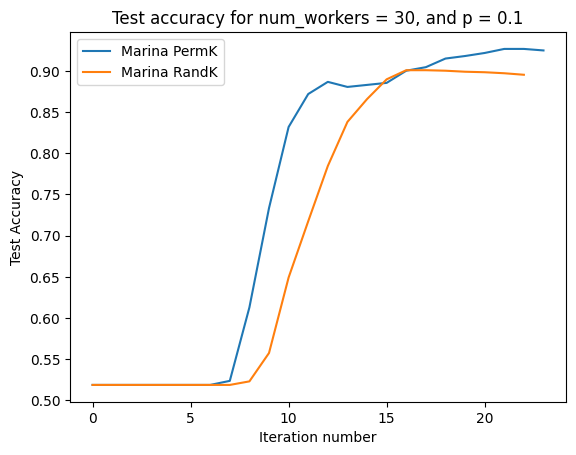

 23%|██▎       | 23/100 [00:37<02:05,  1.62s/it]


Marina with RandK compressor with 100 workers, took 38.61894941329956 seconds


 22%|██▏       | 22/100 [00:33<01:59,  1.54s/it]


Marina with PermK compressor with 100 workers, took 35.08521366119385 seconds


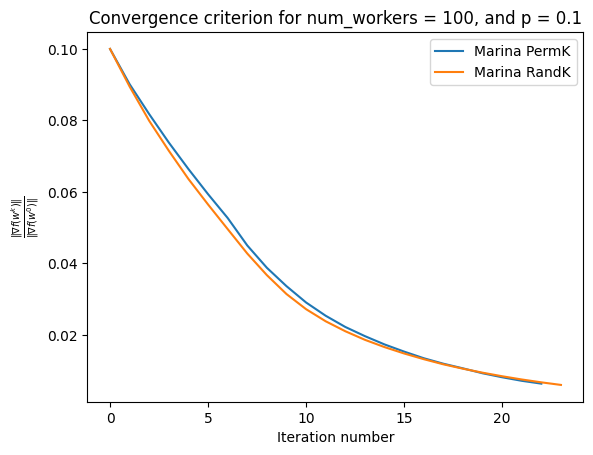

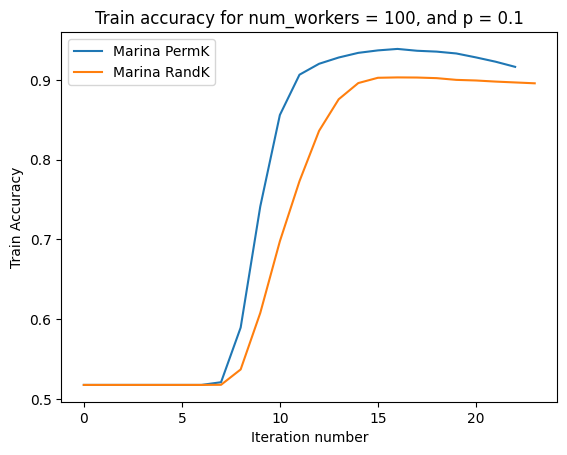

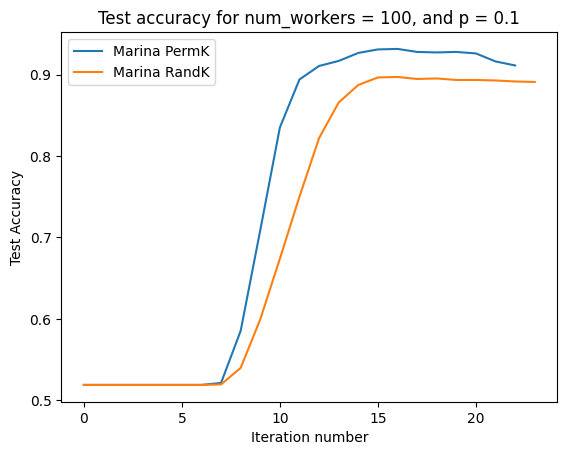

 22%|██▏       | 22/100 [00:36<02:08,  1.65s/it]


Marina with RandK compressor with 110 workers, took 37.61606192588806 seconds


 23%|██▎       | 23/100 [00:36<02:02,  1.59s/it]


Marina with PermK compressor with 110 workers, took 38.94372487068176 seconds


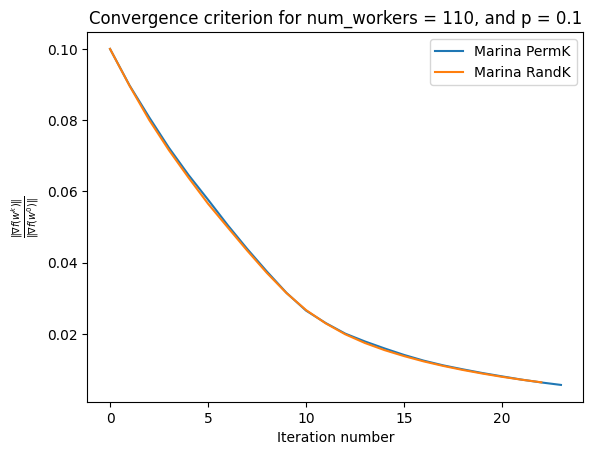

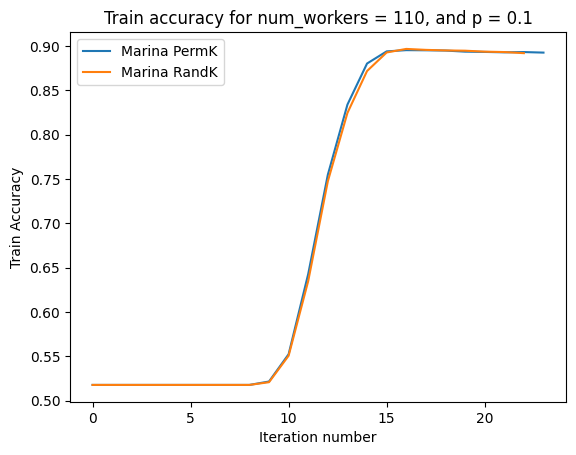

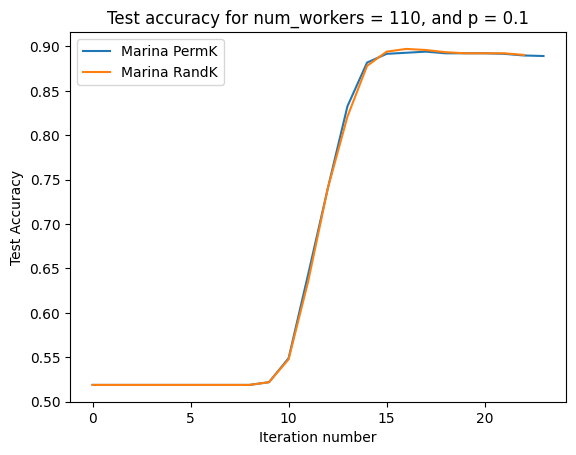

 22%|██▏       | 22/100 [00:31<01:50,  1.42s/it]


Marina with RandK compressor with 10 workers, took 32.30829882621765 seconds


 23%|██▎       | 23/100 [00:29<01:39,  1.29s/it]


Marina with PermK compressor with 10 workers, took 30.646461725234985 seconds


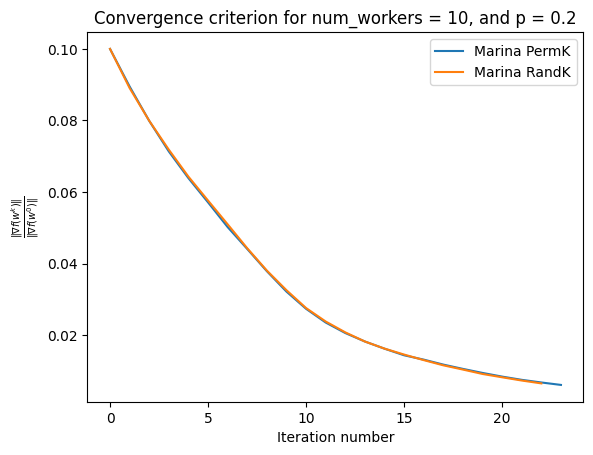

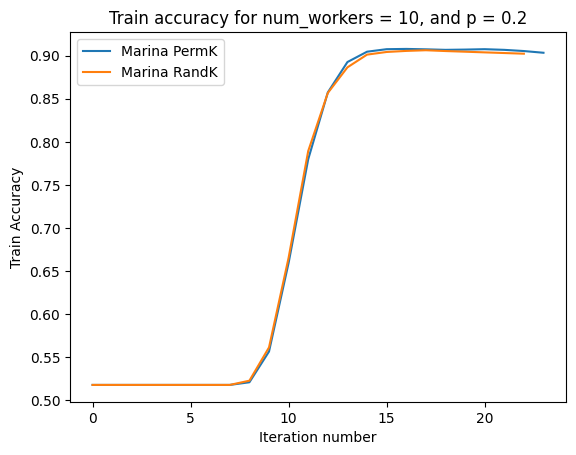

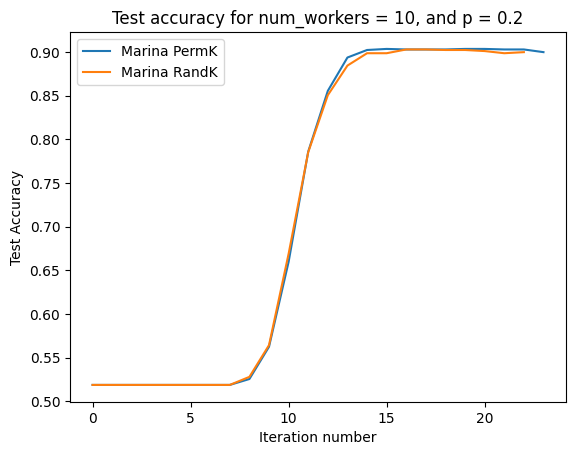

 22%|██▏       | 22/100 [00:31<01:53,  1.45s/it]


Marina with RandK compressor with 30 workers, took 33.07582688331604 seconds


 23%|██▎       | 23/100 [00:34<01:55,  1.49s/it]


Marina with PermK compressor with 30 workers, took 35.602604389190674 seconds


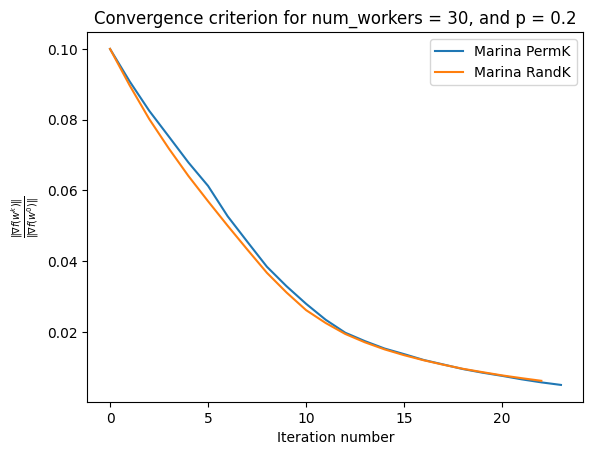

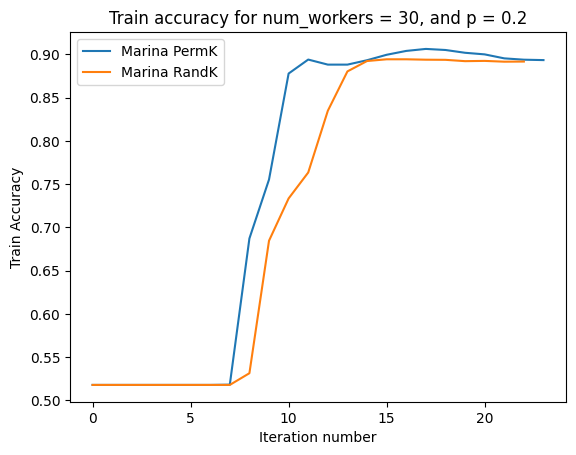

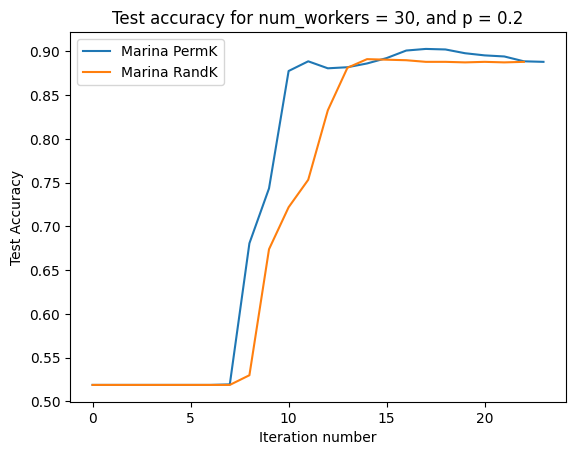

 22%|██▏       | 22/100 [00:33<01:59,  1.54s/it]


Marina with RandK compressor with 100 workers, took 35.79910159111023 seconds


 25%|██▌       | 25/100 [00:37<01:53,  1.51s/it]


Marina with PermK compressor with 100 workers, took 39.052430868148804 seconds


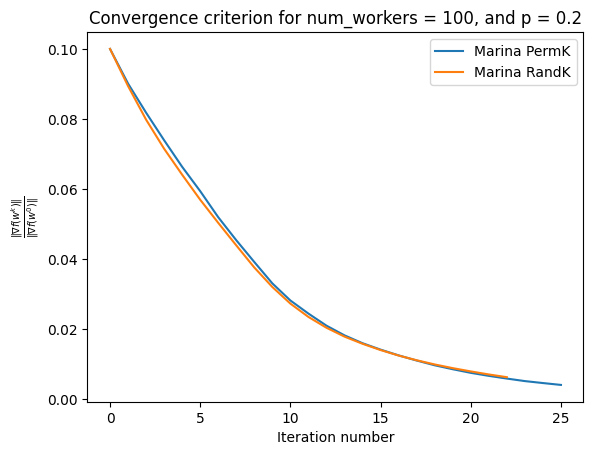

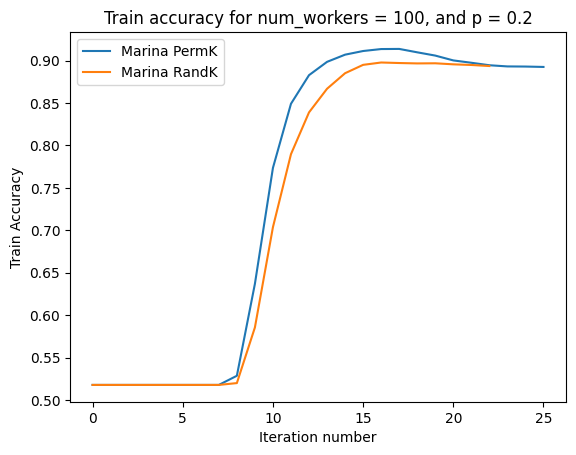

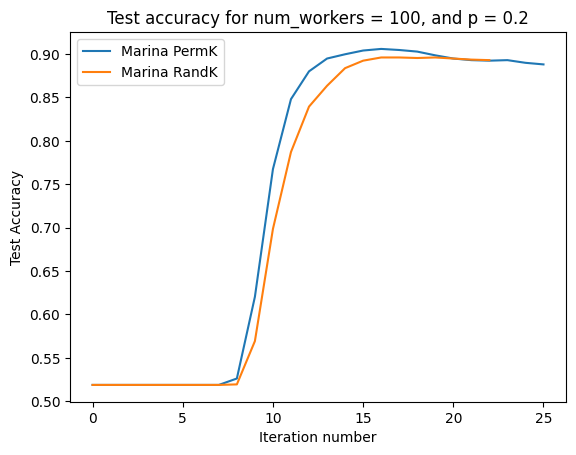

 22%|██▏       | 22/100 [00:34<02:02,  1.58s/it]


Marina with RandK compressor with 110 workers, took 37.02426767349243 seconds


 22%|██▏       | 22/100 [00:36<02:10,  1.67s/it]


Marina with PermK compressor with 110 workers, took 38.17335629463196 seconds


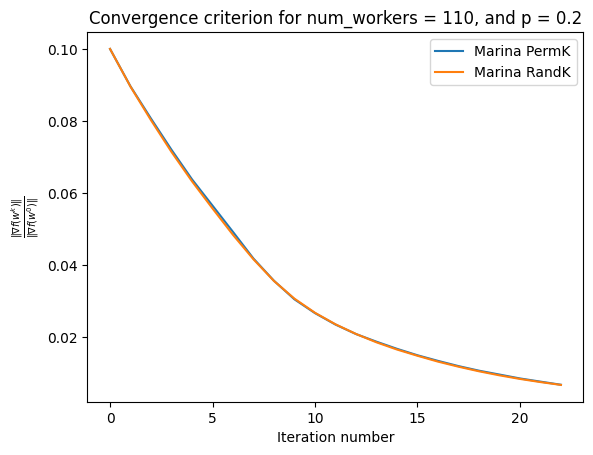

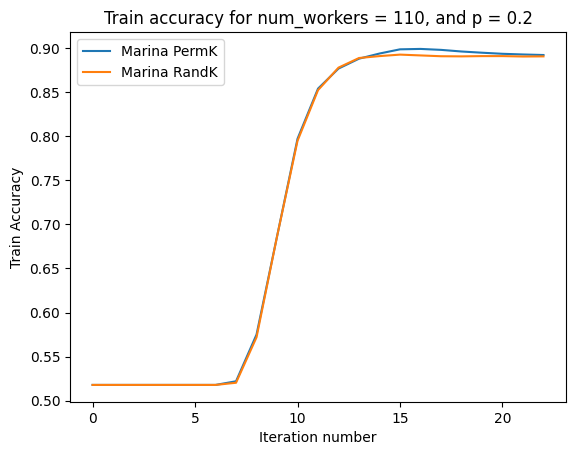

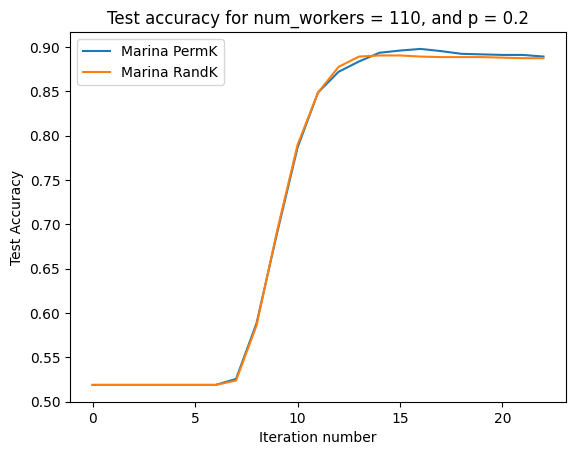

 22%|██▏       | 22/100 [00:27<01:38,  1.26s/it]


Marina with RandK compressor with 10 workers, took 29.24357557296753 seconds


 22%|██▏       | 22/100 [00:28<01:41,  1.30s/it]


Marina with PermK compressor with 10 workers, took 29.727716207504272 seconds


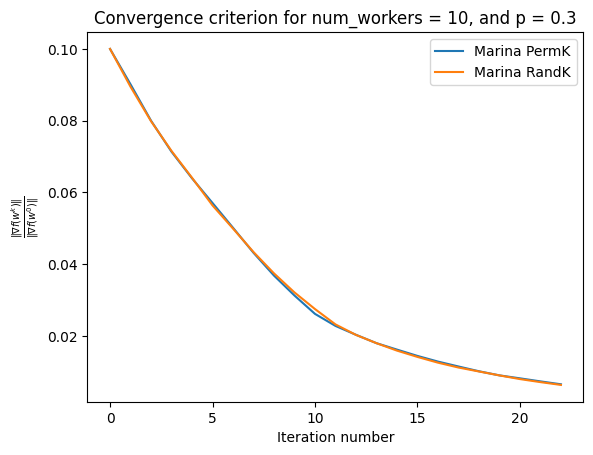

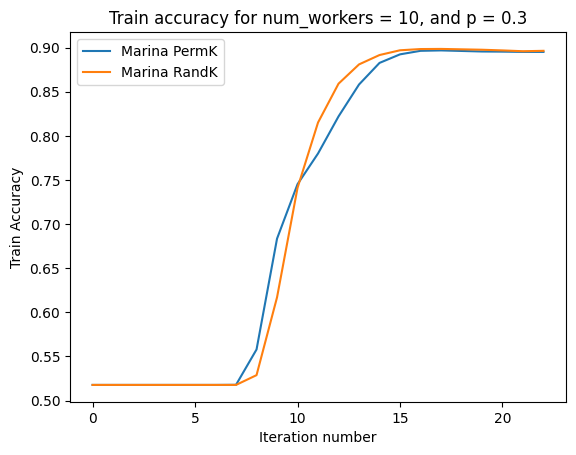

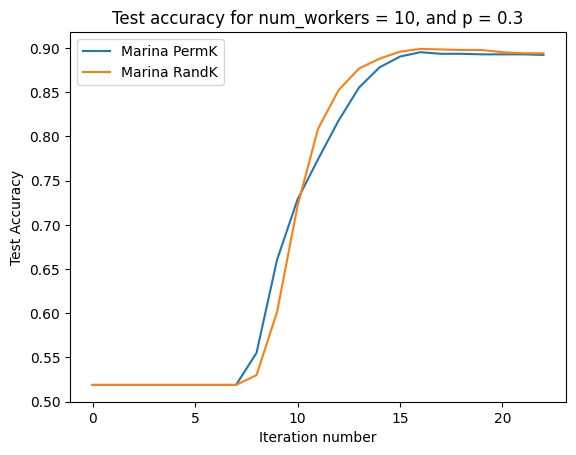

 21%|██        | 21/100 [00:30<01:54,  1.45s/it]


Marina with RandK compressor with 30 workers, took 31.604655504226685 seconds


 22%|██▏       | 22/100 [00:31<01:51,  1.43s/it]


Marina with PermK compressor with 30 workers, took 32.59578990936279 seconds


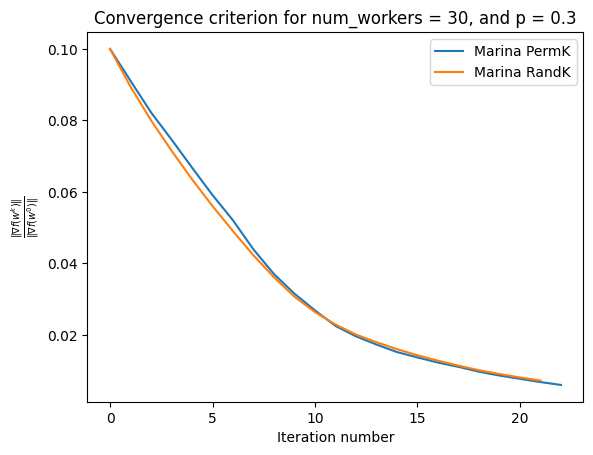

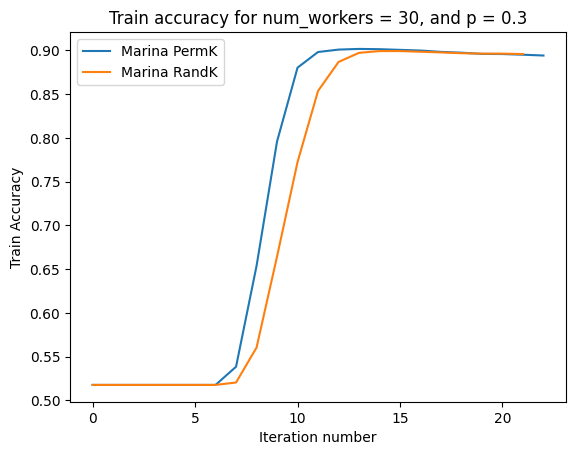

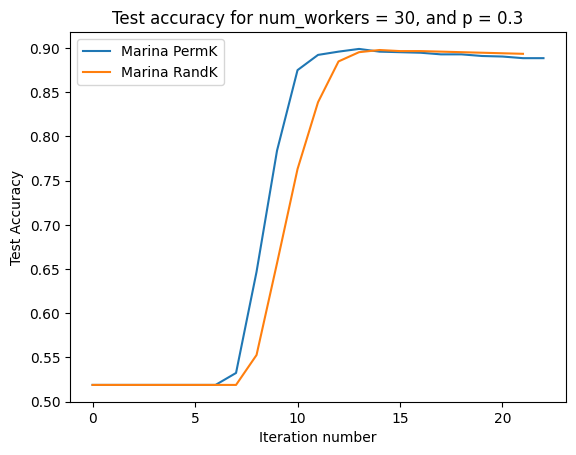

 21%|██        | 21/100 [00:33<02:04,  1.57s/it]


Marina with RandK compressor with 100 workers, took 35.153271198272705 seconds


 22%|██▏       | 22/100 [00:33<01:58,  1.52s/it]


Marina with PermK compressor with 100 workers, took 34.80334496498108 seconds


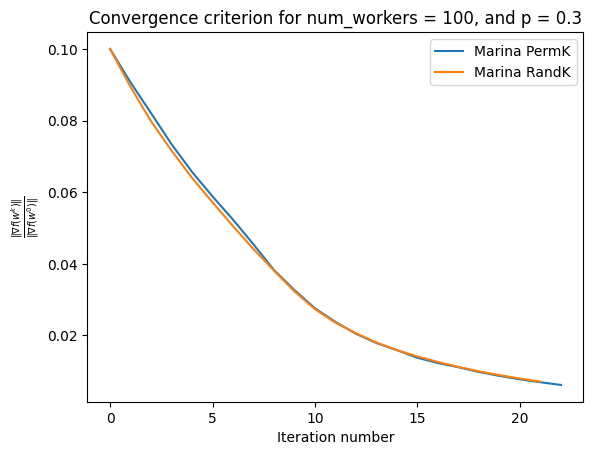

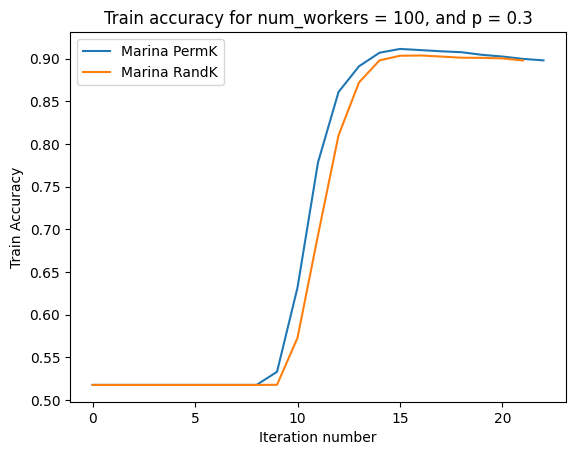

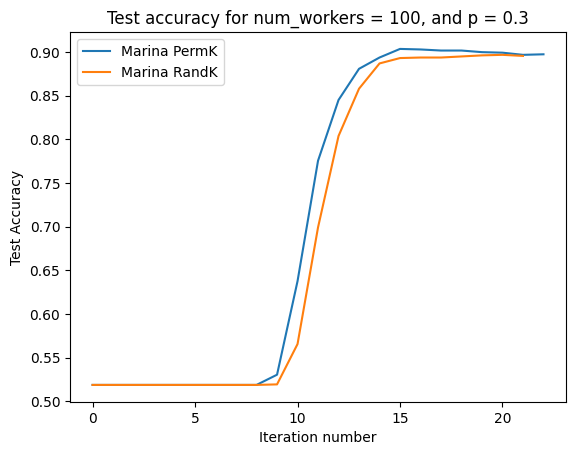

 21%|██        | 21/100 [00:33<02:07,  1.61s/it]


Marina with RandK compressor with 110 workers, took 35.15852689743042 seconds


 22%|██▏       | 22/100 [00:39<02:19,  1.79s/it]


Marina with PermK compressor with 110 workers, took 41.06445813179016 seconds


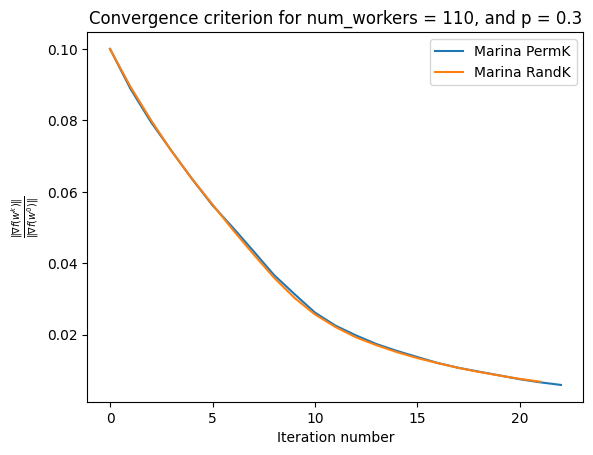

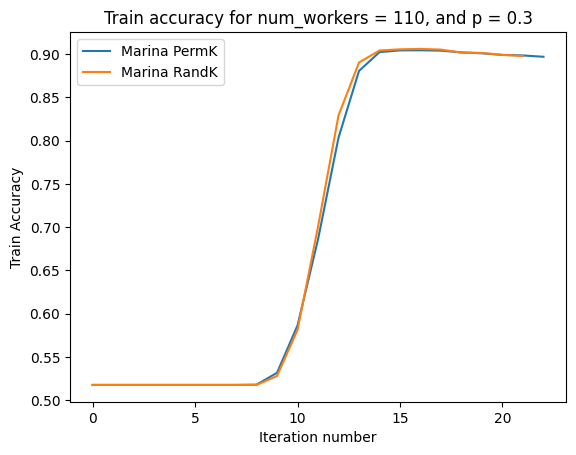

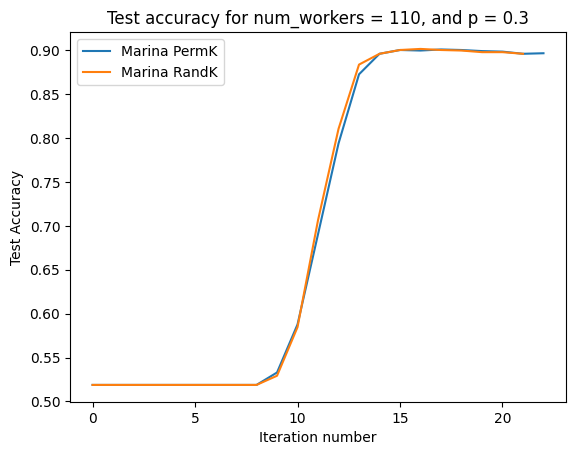

 22%|██▏       | 22/100 [00:28<01:41,  1.31s/it]


Marina with RandK compressor with 10 workers, took 29.730913877487183 seconds


 22%|██▏       | 22/100 [00:27<01:37,  1.26s/it]


Marina with PermK compressor with 10 workers, took 28.689372539520264 seconds


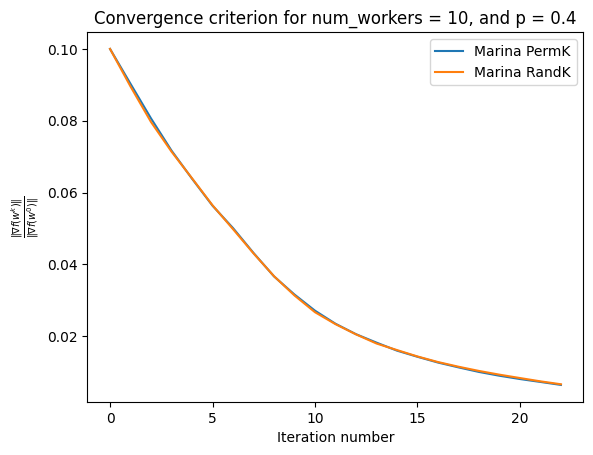

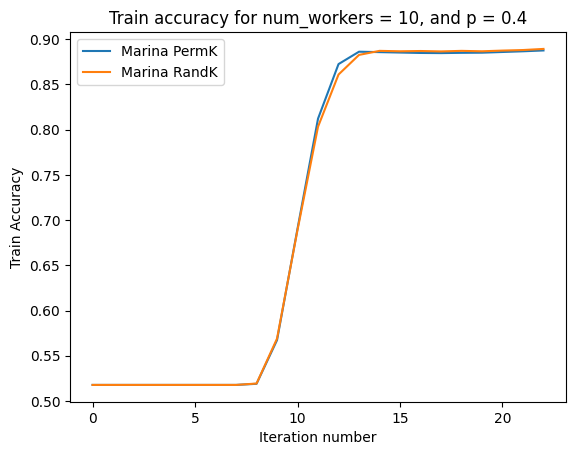

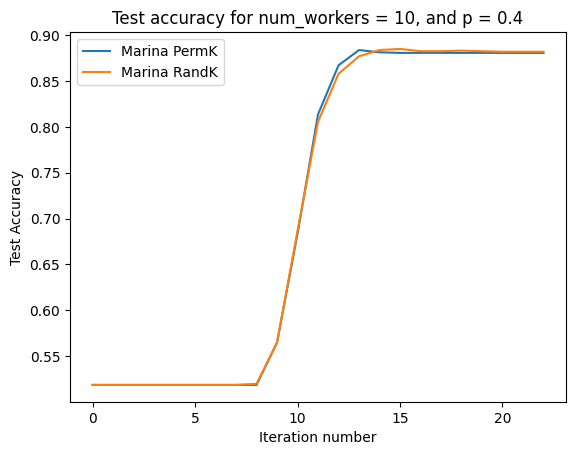

 22%|██▏       | 22/100 [00:37<02:12,  1.69s/it]


Marina with RandK compressor with 30 workers, took 38.698630809783936 seconds


 22%|██▏       | 22/100 [00:32<01:54,  1.47s/it]


Marina with PermK compressor with 30 workers, took 33.60608744621277 seconds


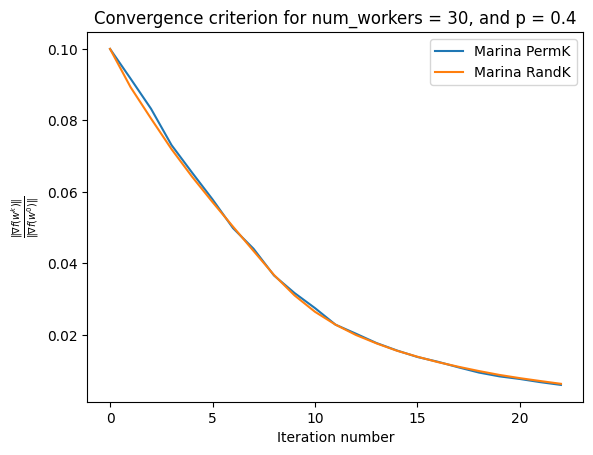

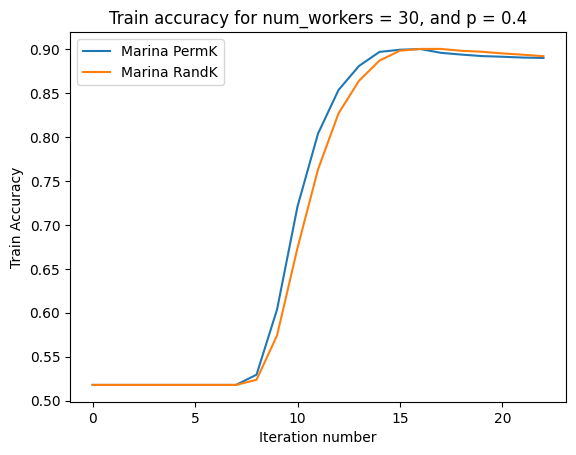

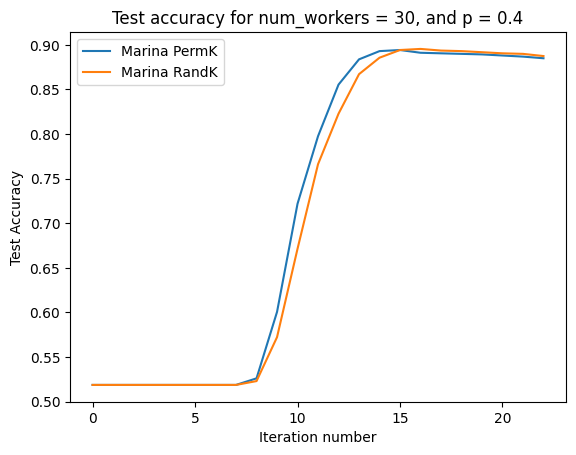

 22%|██▏       | 22/100 [00:42<02:31,  1.94s/it]


Marina with RandK compressor with 100 workers, took 44.87898898124695 seconds


 22%|██▏       | 22/100 [00:41<02:26,  1.88s/it]


Marina with PermK compressor with 100 workers, took 44.492271184921265 seconds


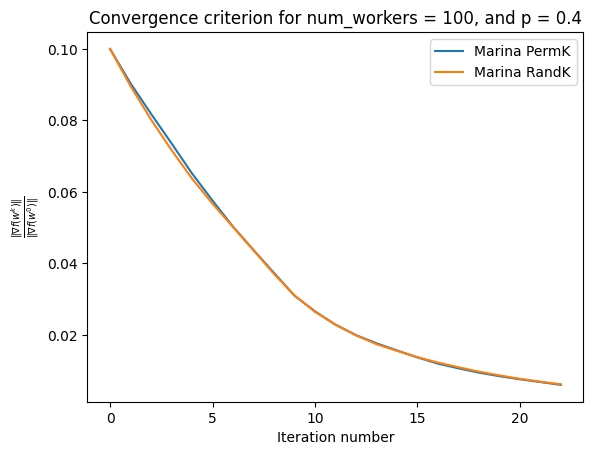

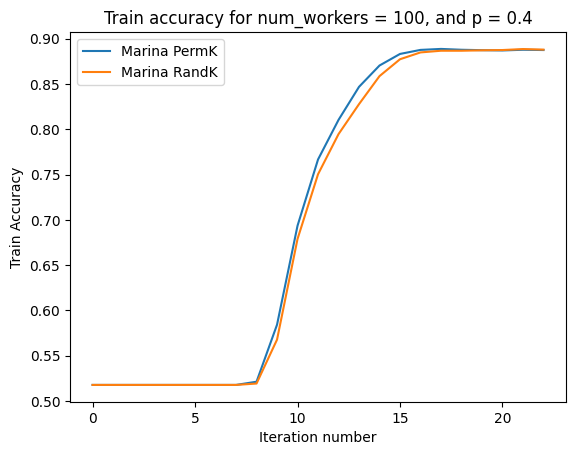

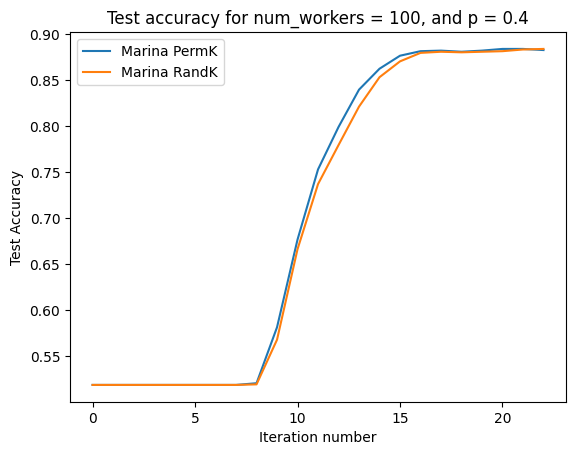

 23%|██▎       | 23/100 [00:38<02:07,  1.66s/it]


Marina with RandK compressor with 110 workers, took 39.435381174087524 seconds


 22%|██▏       | 22/100 [00:35<02:05,  1.61s/it]


Marina with PermK compressor with 110 workers, took 37.63364553451538 seconds


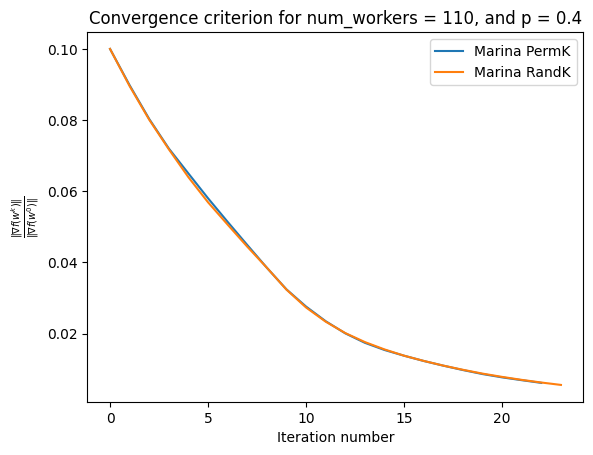

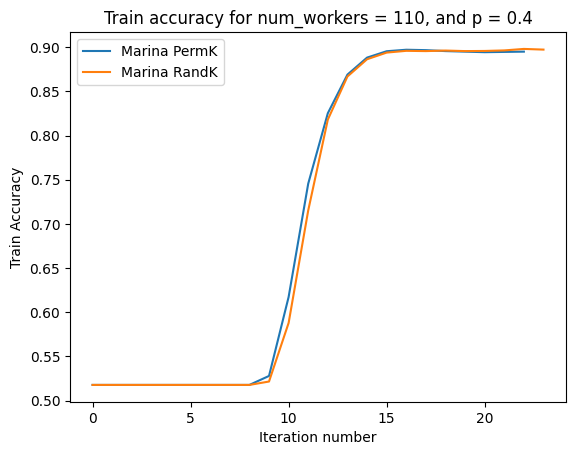

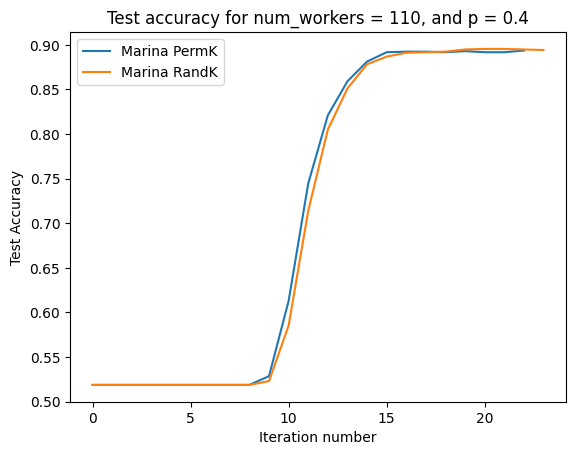

 22%|██▏       | 22/100 [00:28<01:41,  1.30s/it]


Marina with RandK compressor with 10 workers, took 29.599528312683105 seconds


 22%|██▏       | 22/100 [00:28<01:41,  1.30s/it]


Marina with PermK compressor with 10 workers, took 29.63798475265503 seconds


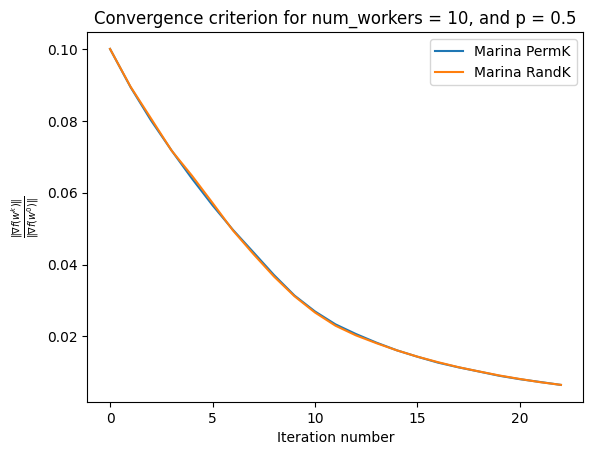

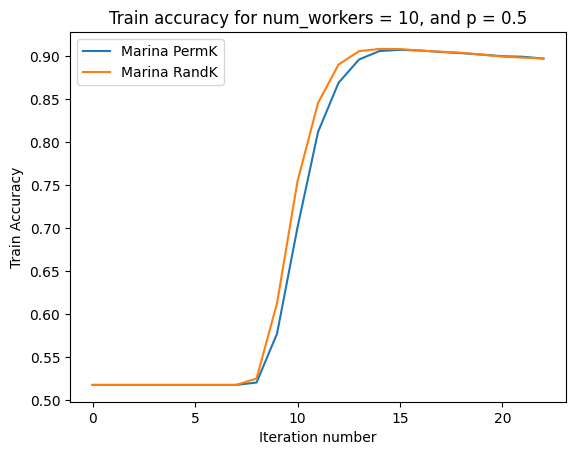

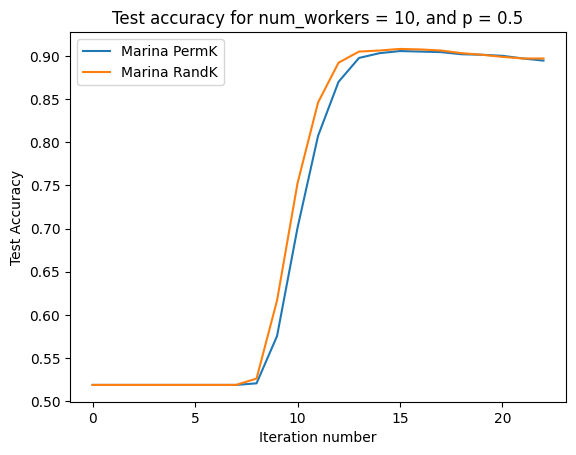

 21%|██        | 21/100 [00:31<01:57,  1.49s/it]


Marina with RandK compressor with 30 workers, took 32.443872690200806 seconds


 22%|██▏       | 22/100 [00:32<01:54,  1.47s/it]


Marina with PermK compressor with 30 workers, took 33.65445160865784 seconds


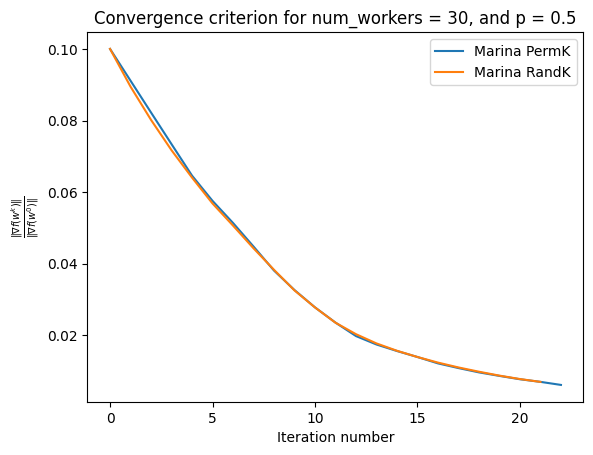

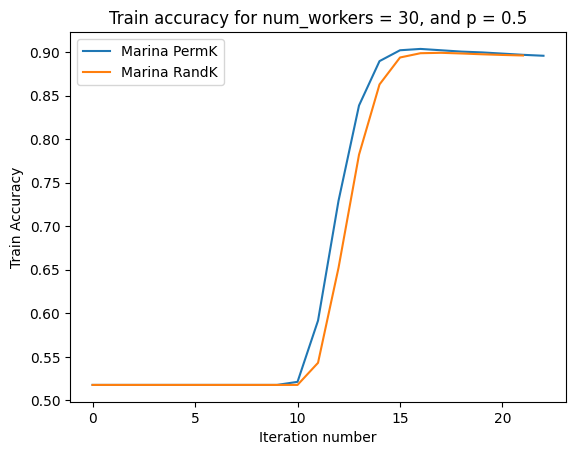

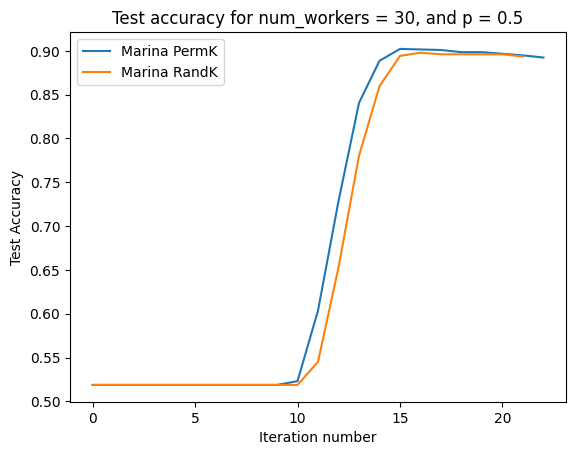

 21%|██        | 21/100 [00:34<02:11,  1.66s/it]


Marina with RandK compressor with 100 workers, took 36.07979393005371 seconds


 21%|██        | 21/100 [00:33<02:07,  1.62s/it]


Marina with PermK compressor with 100 workers, took 36.61210036277771 seconds


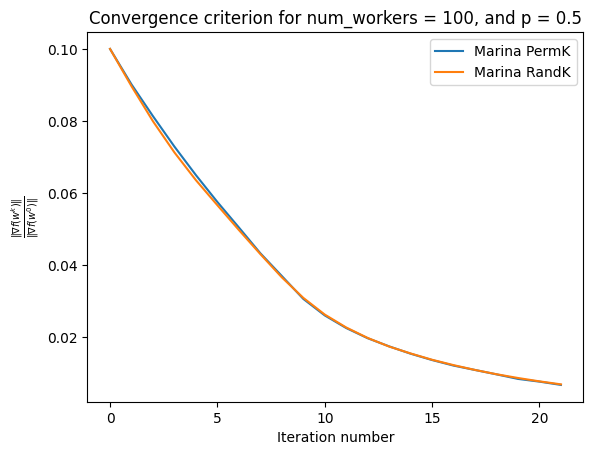

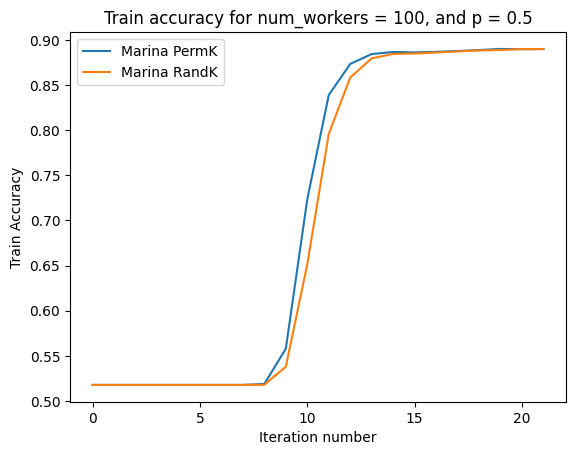

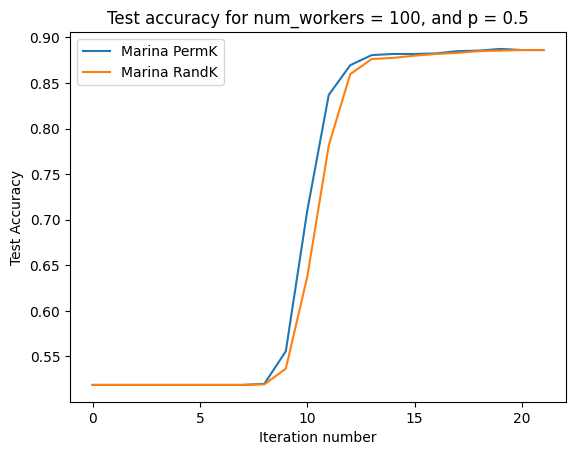

 21%|██        | 21/100 [00:33<02:07,  1.62s/it]


Marina with RandK compressor with 110 workers, took 35.27842903137207 seconds


 22%|██▏       | 22/100 [00:36<02:10,  1.68s/it]


Marina with PermK compressor with 110 workers, took 38.29502868652344 seconds


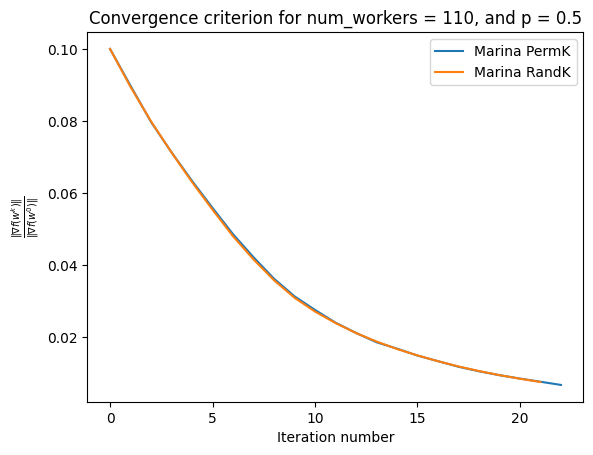

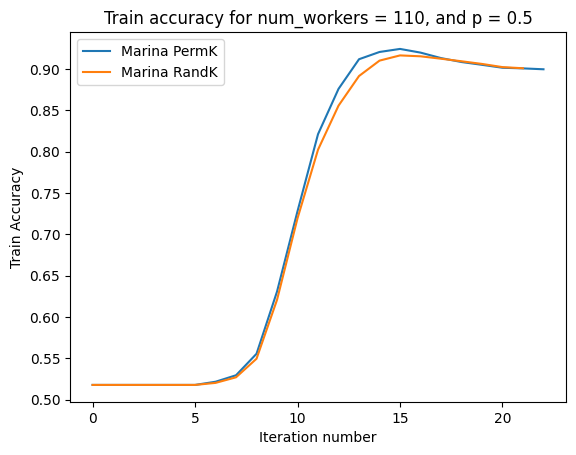

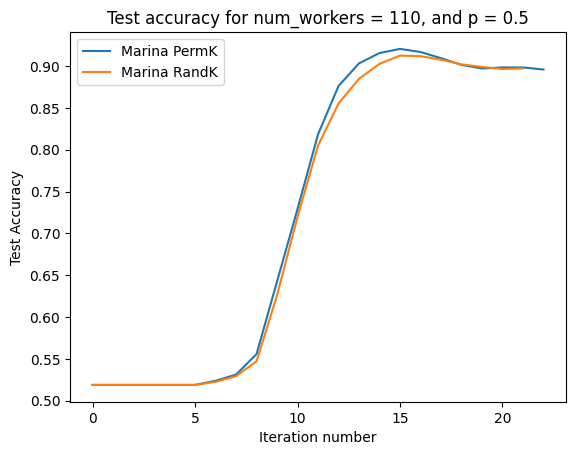

 22%|██▏       | 22/100 [00:27<01:38,  1.27s/it]


Marina with RandK compressor with 10 workers, took 28.87444543838501 seconds


 22%|██▏       | 22/100 [00:26<01:35,  1.23s/it]


Marina with PermK compressor with 10 workers, took 28.80789804458618 seconds


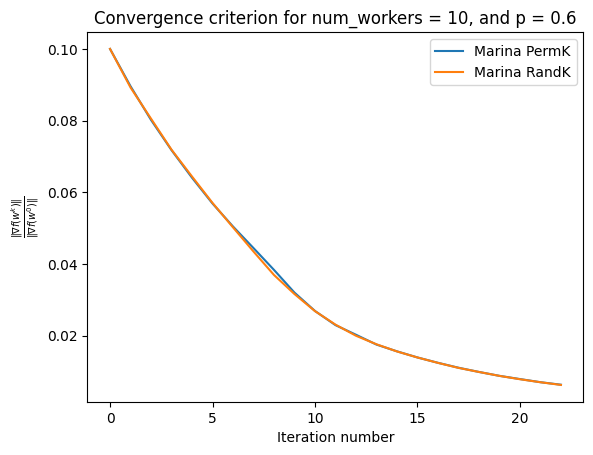

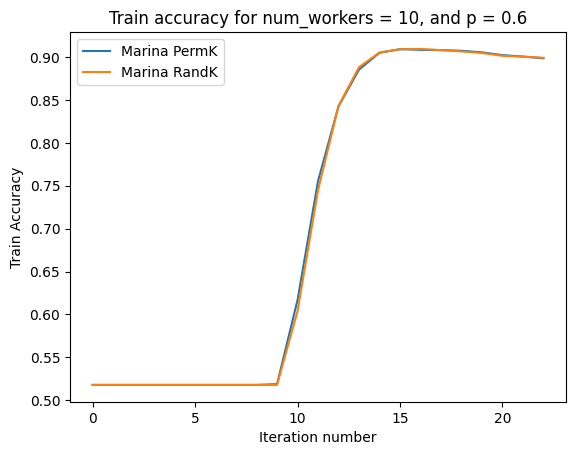

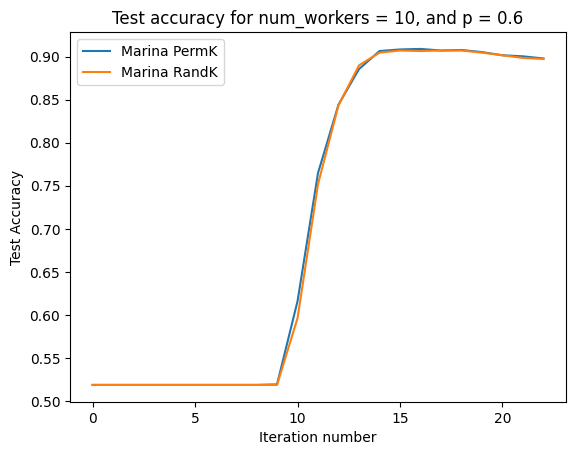

 21%|██        | 21/100 [00:31<01:57,  1.48s/it]


Marina with RandK compressor with 30 workers, took 33.145973682403564 seconds


 22%|██▏       | 22/100 [00:32<01:54,  1.47s/it]


Marina with PermK compressor with 30 workers, took 33.7942168712616 seconds


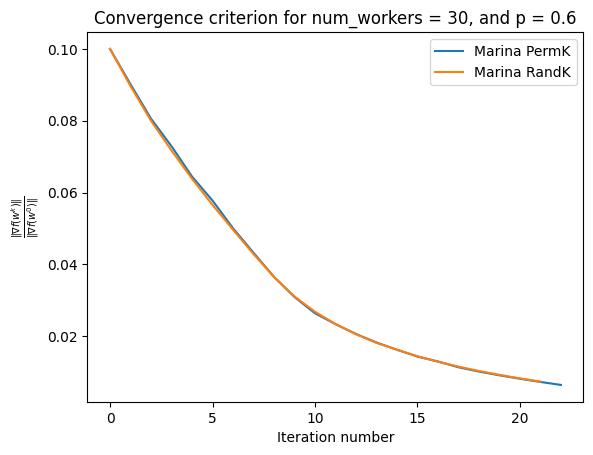

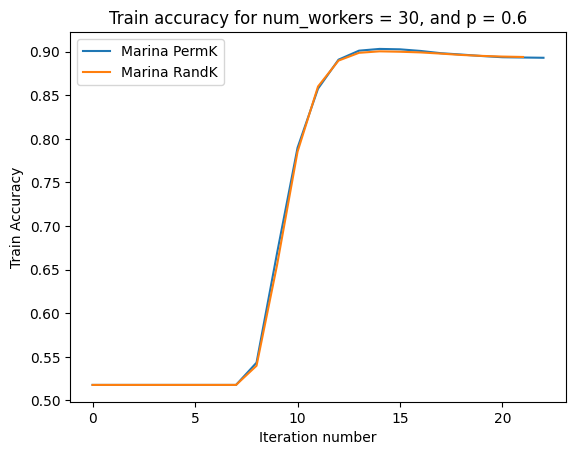

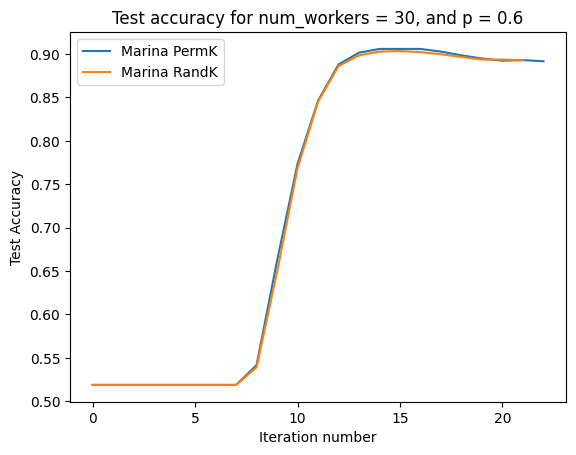

 22%|██▏       | 22/100 [00:36<02:10,  1.68s/it]


Marina with RandK compressor with 100 workers, took 38.17082977294922 seconds


 22%|██▏       | 22/100 [00:35<02:07,  1.63s/it]


Marina with PermK compressor with 100 workers, took 37.717581272125244 seconds


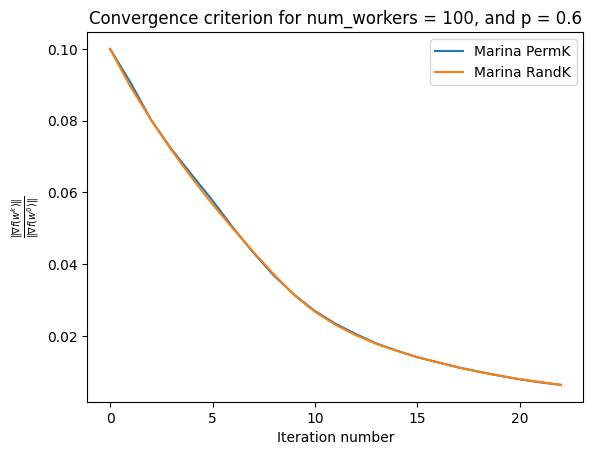

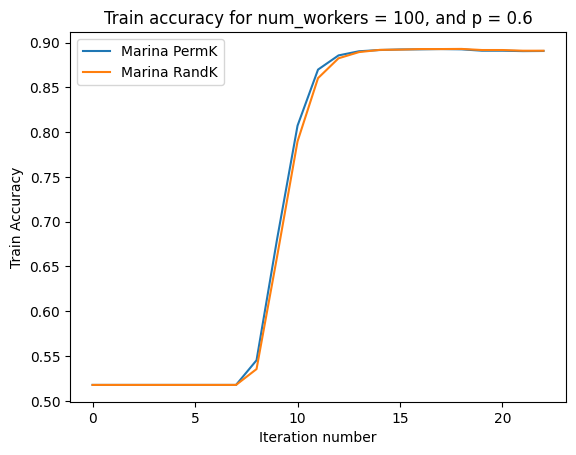

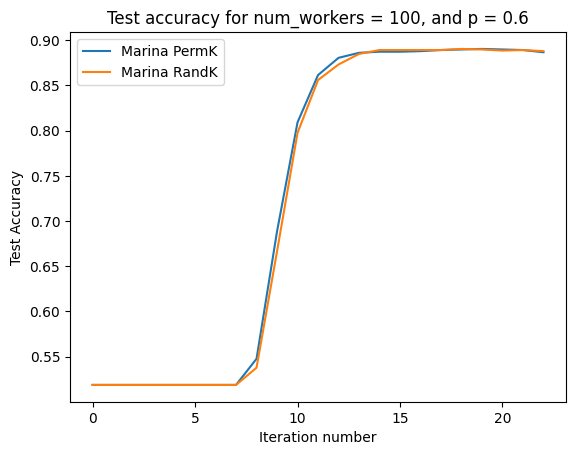

 21%|██        | 21/100 [00:33<02:07,  1.61s/it]


Marina with RandK compressor with 110 workers, took 35.14473509788513 seconds


 22%|██▏       | 22/100 [00:38<02:14,  1.73s/it]


Marina with PermK compressor with 110 workers, took 39.44146943092346 seconds


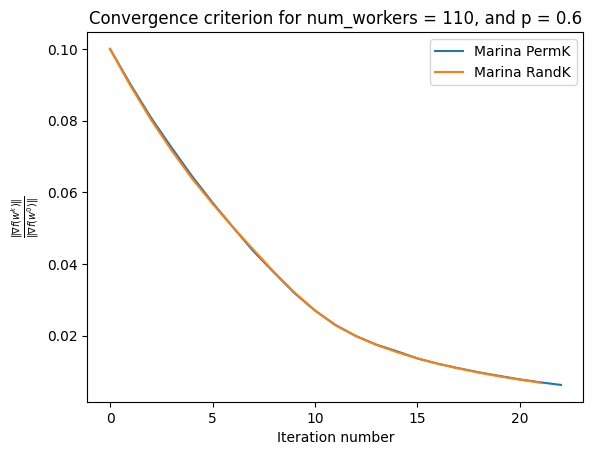

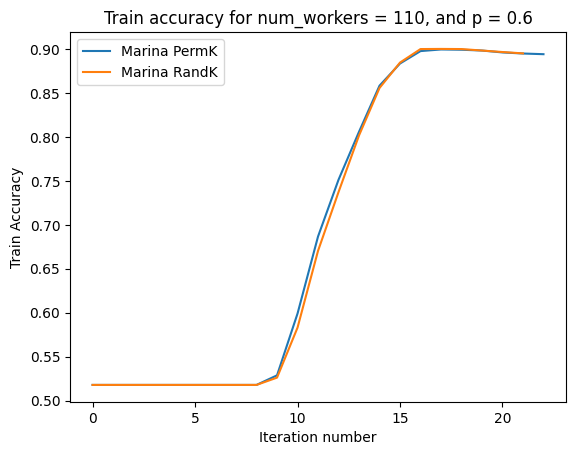

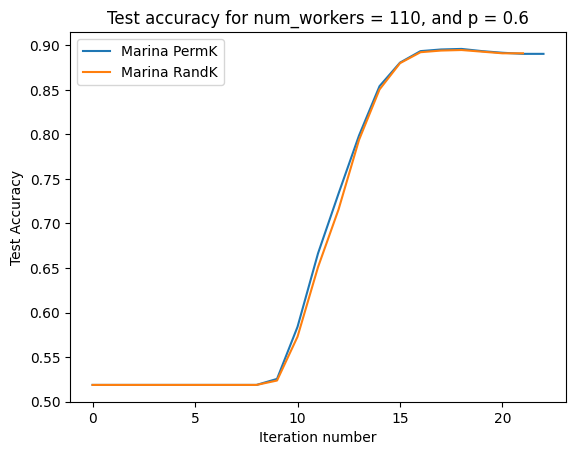

 22%|██▏       | 22/100 [00:28<01:40,  1.29s/it]


Marina with RandK compressor with 10 workers, took 29.512392282485962 seconds


 22%|██▏       | 22/100 [00:27<01:37,  1.25s/it]


Marina with PermK compressor with 10 workers, took 29.0266695022583 seconds


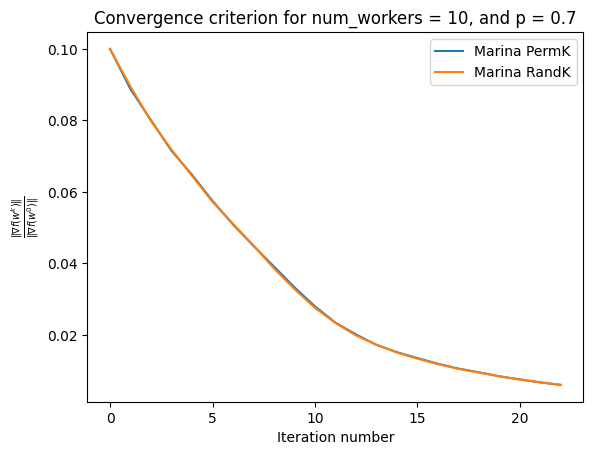

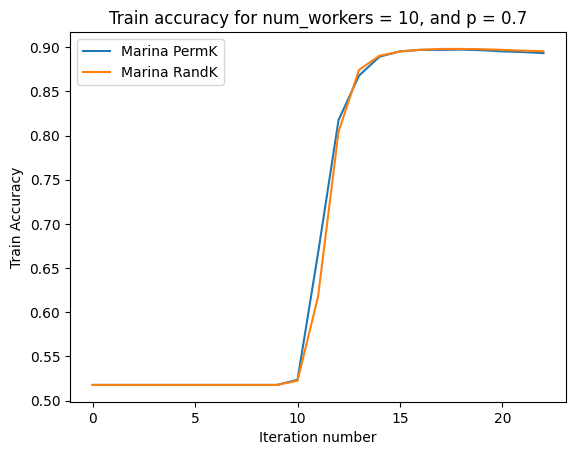

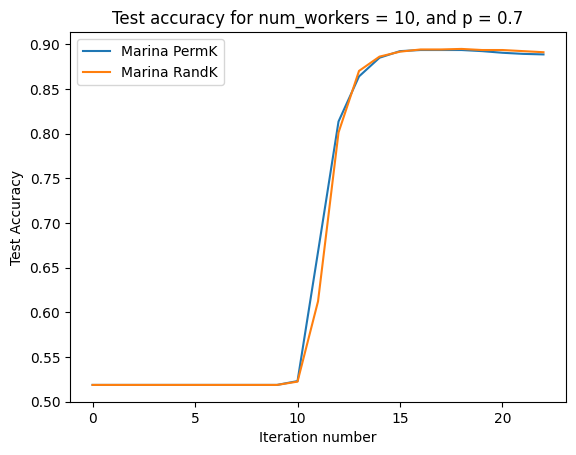

 21%|██        | 21/100 [00:31<01:57,  1.49s/it]


Marina with RandK compressor with 30 workers, took 33.166277170181274 seconds


 21%|██        | 21/100 [00:33<02:05,  1.59s/it]


Marina with PermK compressor with 30 workers, took 34.82970714569092 seconds


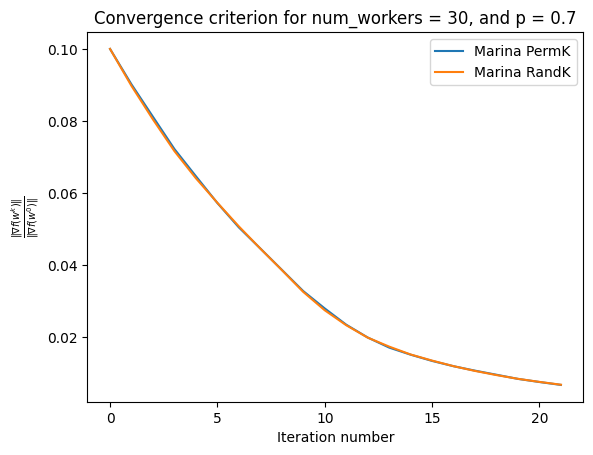

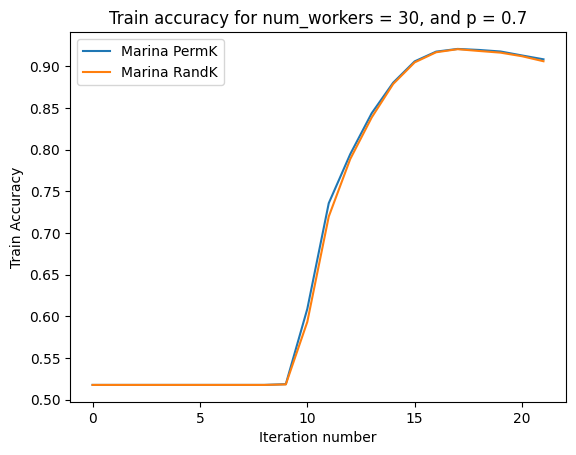

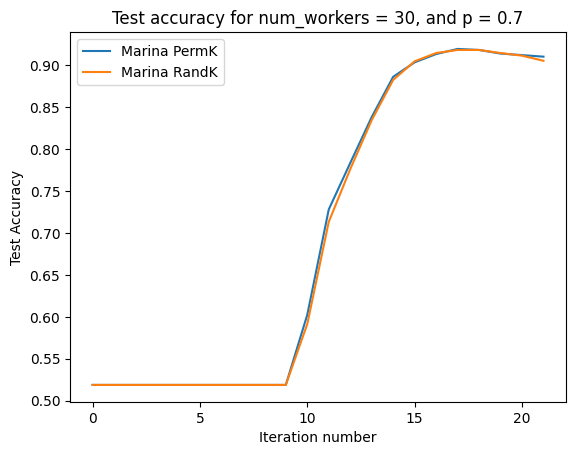

 22%|██▏       | 22/100 [00:33<01:59,  1.53s/it]


Marina with RandK compressor with 100 workers, took 34.969013929367065 seconds


 22%|██▏       | 22/100 [00:36<02:08,  1.65s/it]


Marina with PermK compressor with 100 workers, took 37.74257016181946 seconds


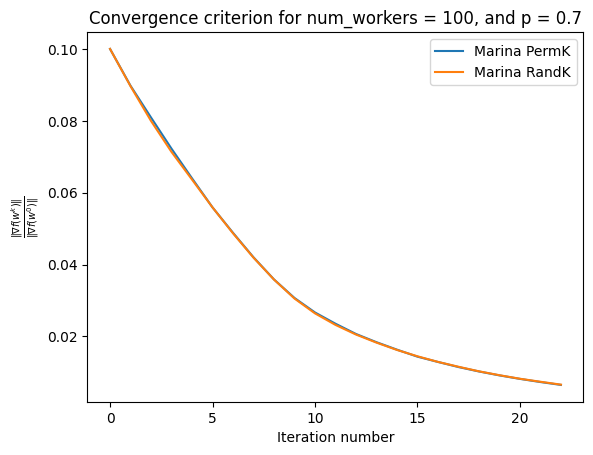

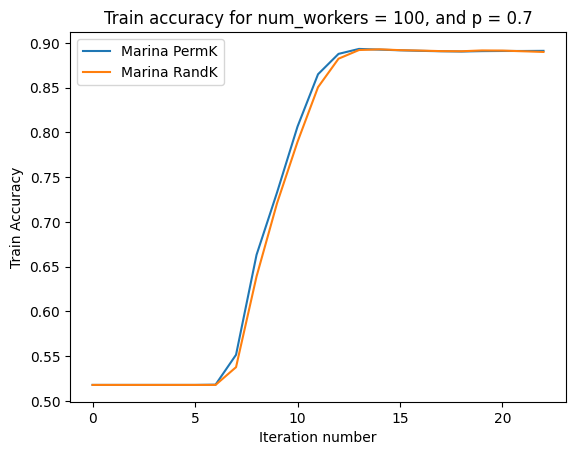

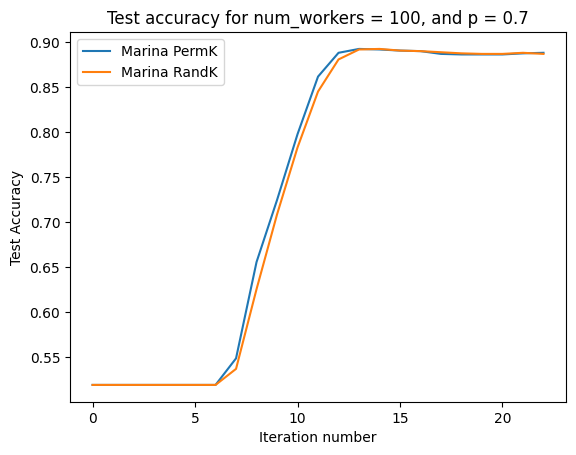

 22%|██▏       | 22/100 [00:36<02:08,  1.64s/it]


Marina with RandK compressor with 110 workers, took 37.439820528030396 seconds


 22%|██▏       | 22/100 [00:38<02:16,  1.75s/it]


Marina with PermK compressor with 110 workers, took 40.01862835884094 seconds


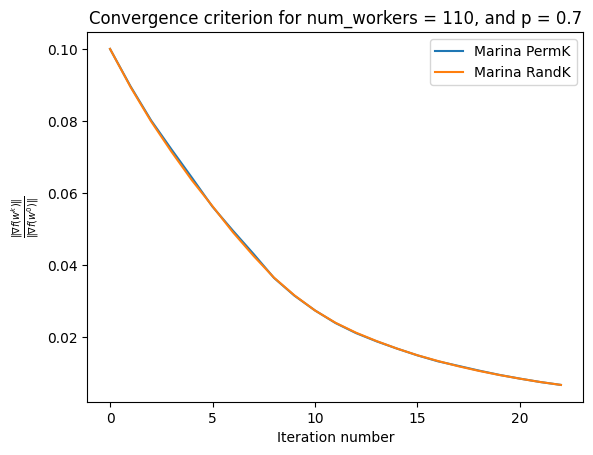

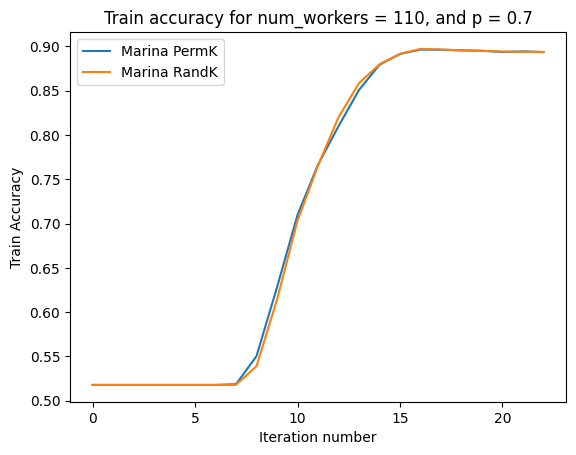

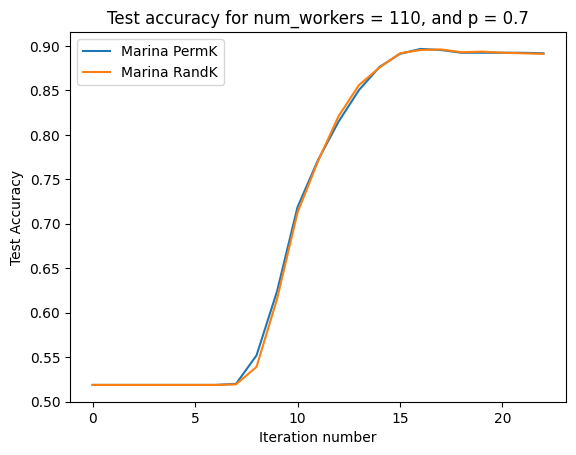

 21%|██        | 21/100 [00:27<01:45,  1.33s/it]


Marina with RandK compressor with 10 workers, took 29.019095182418823 seconds


 22%|██▏       | 22/100 [00:28<01:41,  1.31s/it]


Marina with PermK compressor with 10 workers, took 29.84598469734192 seconds


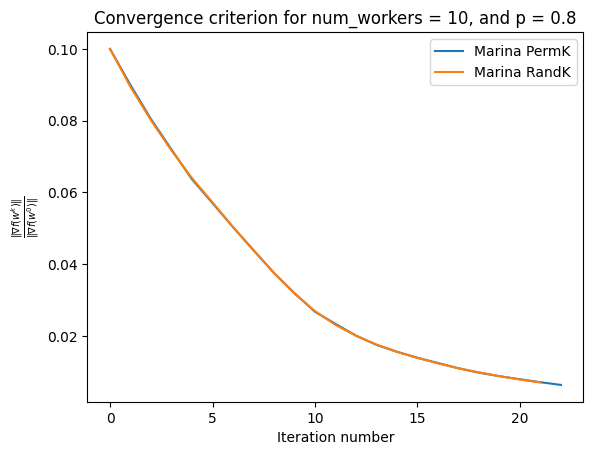

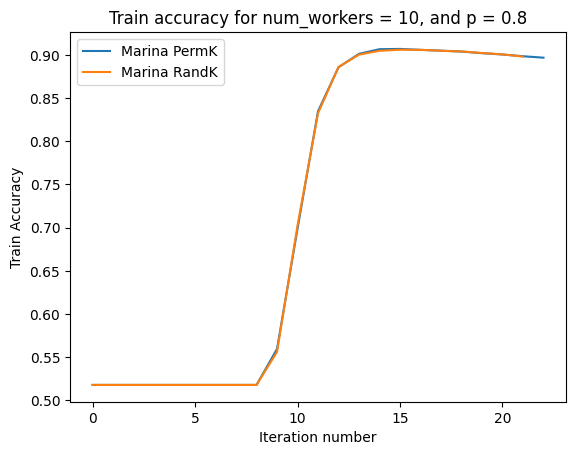

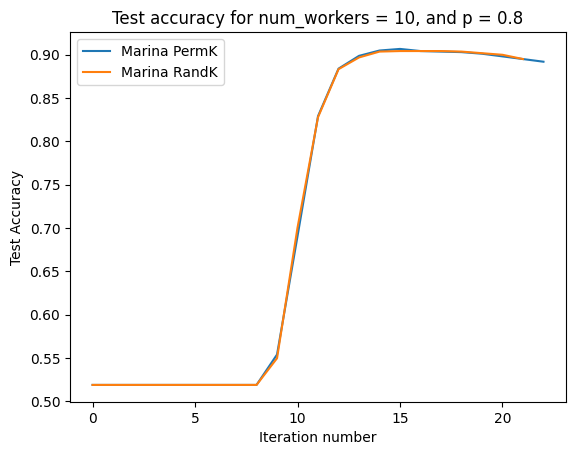

 22%|██▏       | 22/100 [00:33<01:57,  1.51s/it]


Marina with RandK compressor with 30 workers, took 35.44768023490906 seconds


 22%|██▏       | 22/100 [00:32<01:55,  1.48s/it]


Marina with PermK compressor with 30 workers, took 33.745805978775024 seconds


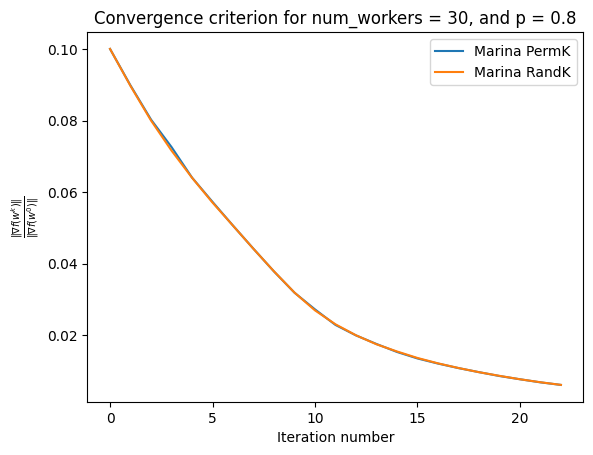

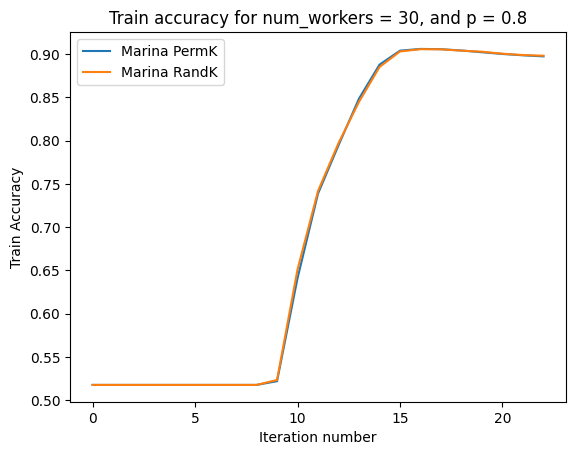

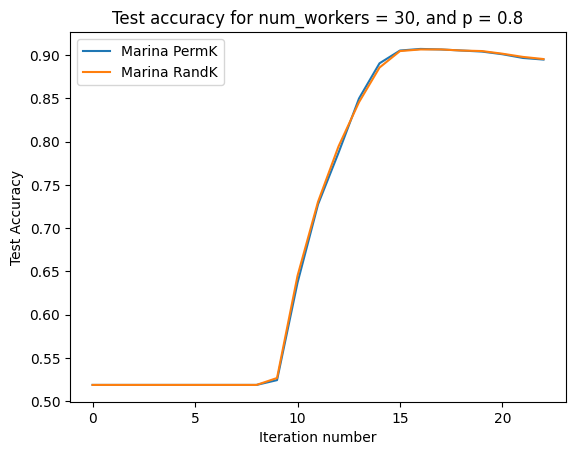

 22%|██▏       | 22/100 [00:34<02:02,  1.58s/it]


Marina with RandK compressor with 100 workers, took 35.92781615257263 seconds


 22%|██▏       | 22/100 [00:37<02:13,  1.72s/it]


Marina with PermK compressor with 100 workers, took 40.017112493515015 seconds


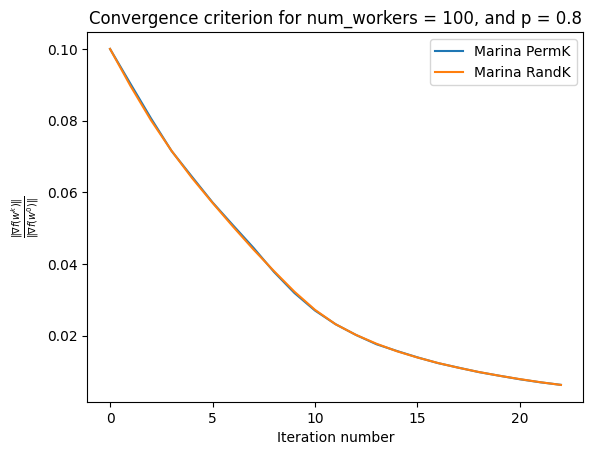

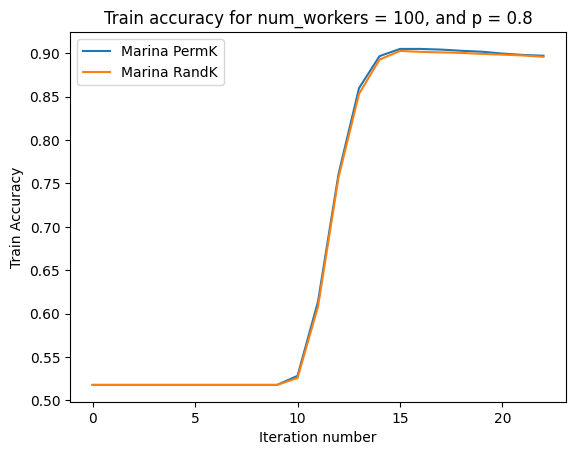

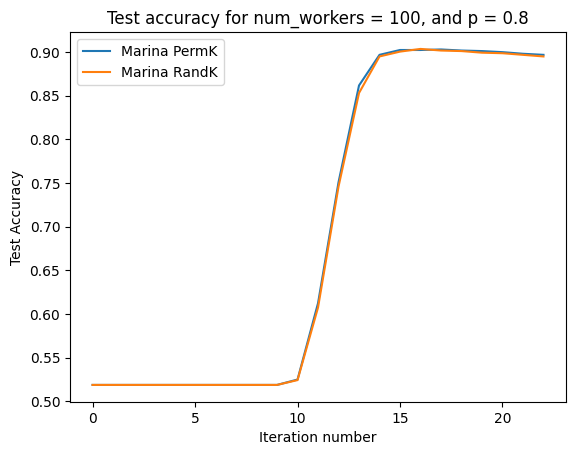

 22%|██▏       | 22/100 [00:45<02:40,  2.06s/it]


Marina with RandK compressor with 110 workers, took 47.385709285736084 seconds


 22%|██▏       | 22/100 [00:37<02:13,  1.72s/it]


Marina with PermK compressor with 110 workers, took 39.226207971572876 seconds


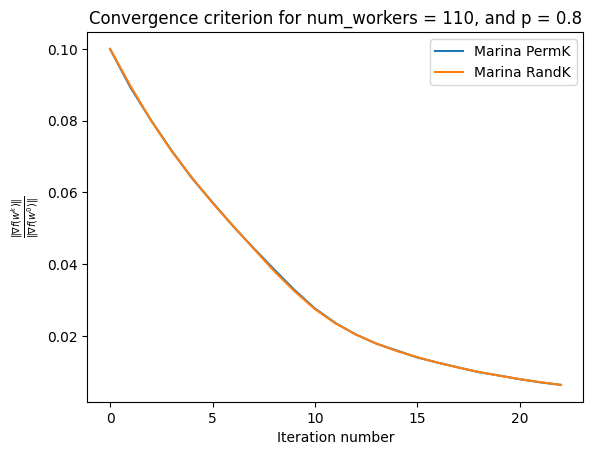

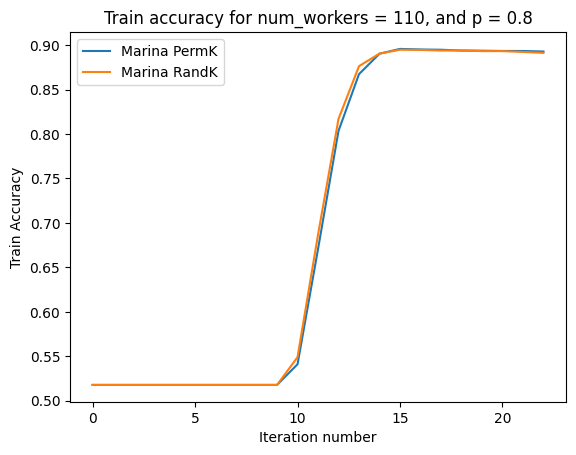

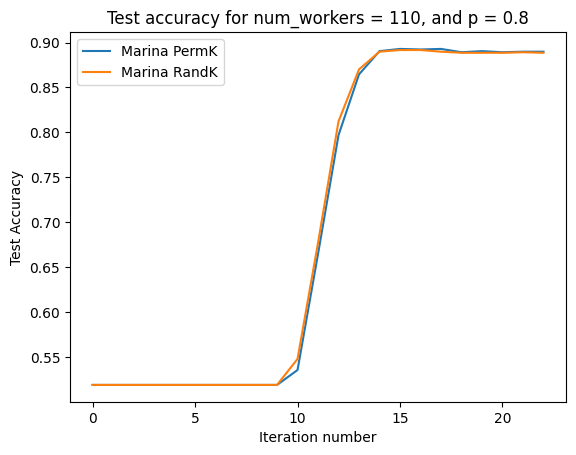

 22%|██▏       | 22/100 [00:31<01:50,  1.42s/it]


Marina with RandK compressor with 10 workers, took 32.276569843292236 seconds


 23%|██▎       | 23/100 [00:30<01:41,  1.31s/it]


Marina with PermK compressor with 10 workers, took 31.319461345672607 seconds


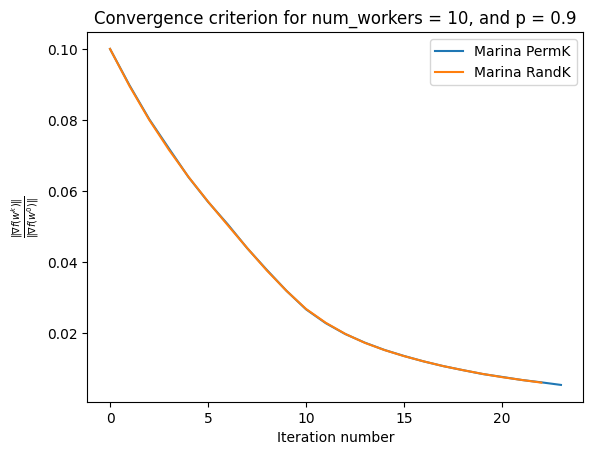

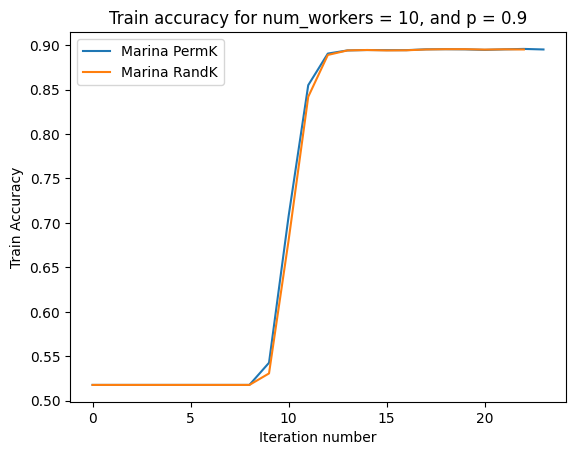

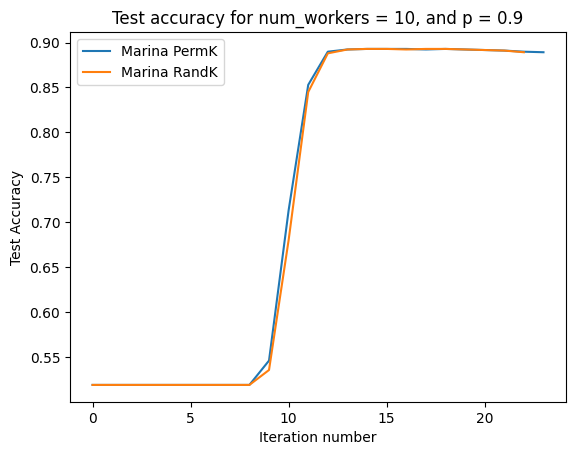

 21%|██        | 21/100 [00:31<01:57,  1.49s/it]


Marina with RandK compressor with 30 workers, took 32.42394948005676 seconds


 22%|██▏       | 22/100 [00:32<01:54,  1.47s/it]


Marina with PermK compressor with 30 workers, took 33.705098390579224 seconds


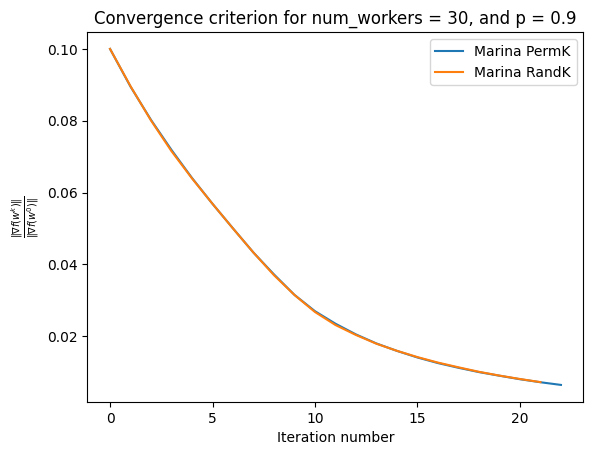

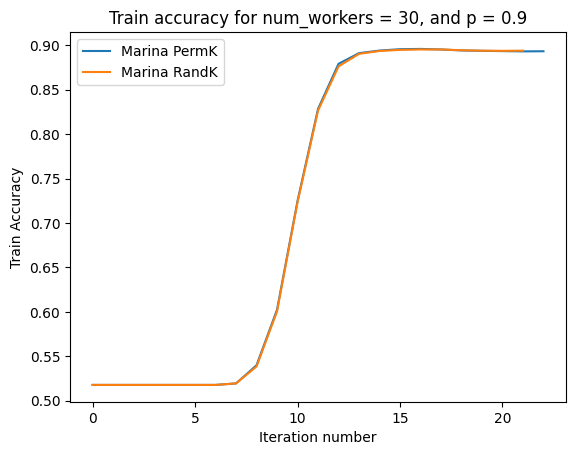

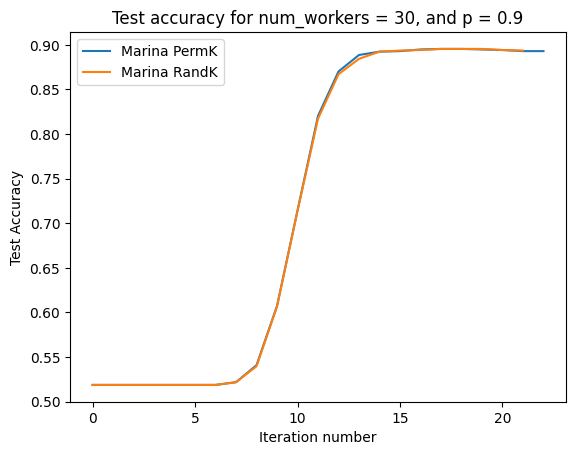

 21%|██        | 21/100 [00:33<02:06,  1.60s/it]


Marina with RandK compressor with 100 workers, took 34.88860845565796 seconds


 21%|██        | 21/100 [00:33<02:06,  1.60s/it]


Marina with PermK compressor with 100 workers, took 35.83771252632141 seconds


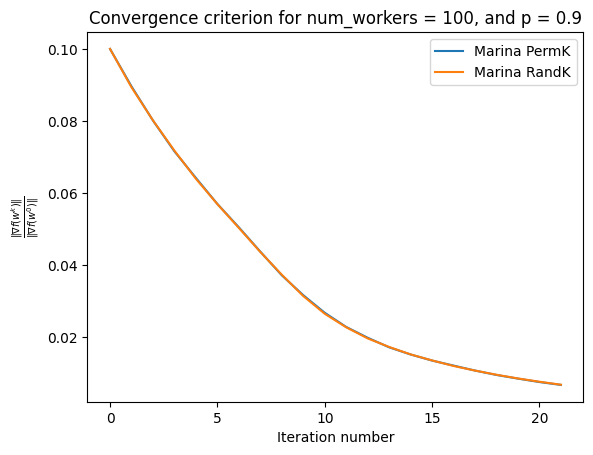

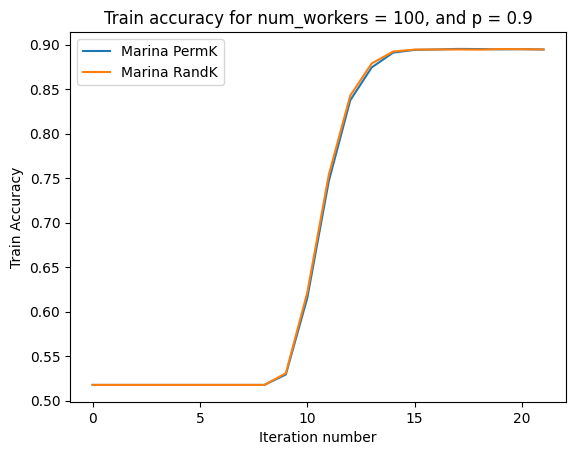

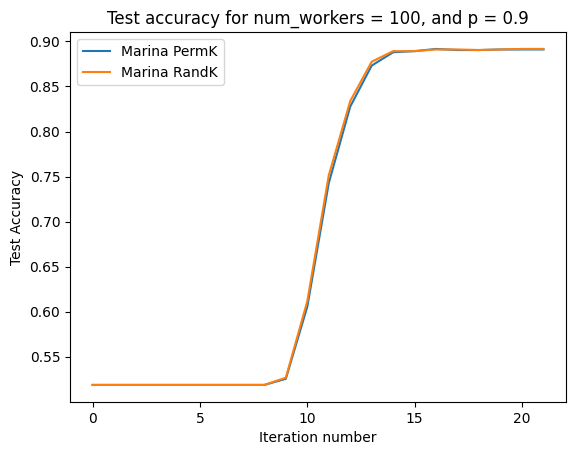

 22%|██▏       | 22/100 [00:35<02:04,  1.60s/it]


Marina with RandK compressor with 110 workers, took 36.44873523712158 seconds


 22%|██▏       | 22/100 [00:40<02:22,  1.83s/it]


Marina with PermK compressor with 110 workers, took 41.769306898117065 seconds


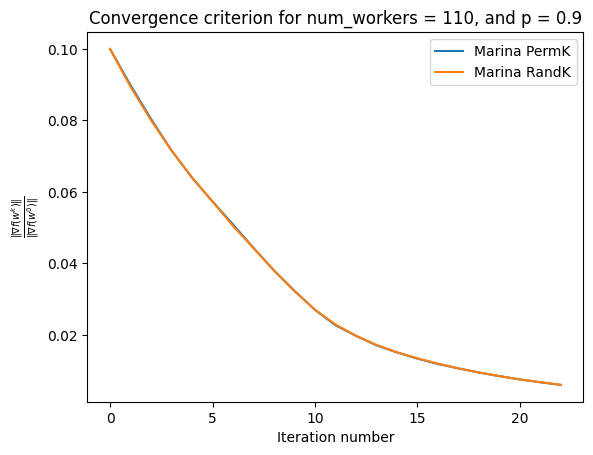

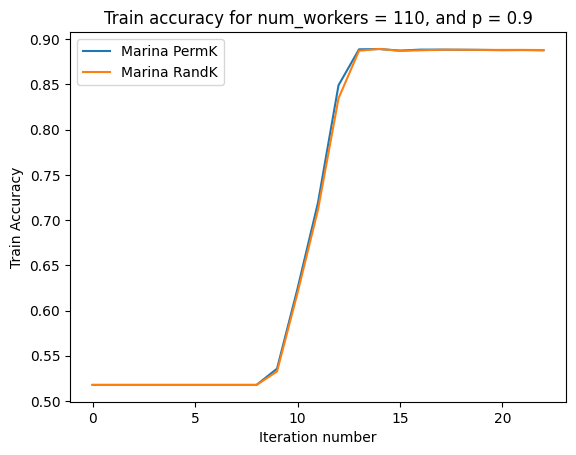

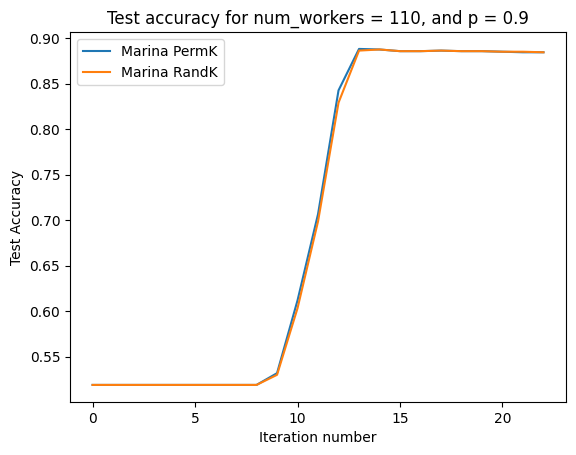

 21%|██        | 21/100 [00:27<01:44,  1.32s/it]


Marina with RandK compressor with 10 workers, took 28.732202291488647 seconds


 21%|██        | 21/100 [00:25<01:36,  1.22s/it]


Marina with PermK compressor with 10 workers, took 27.202816009521484 seconds


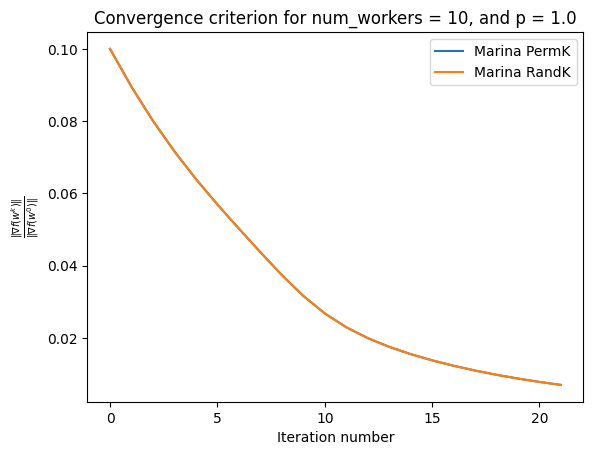

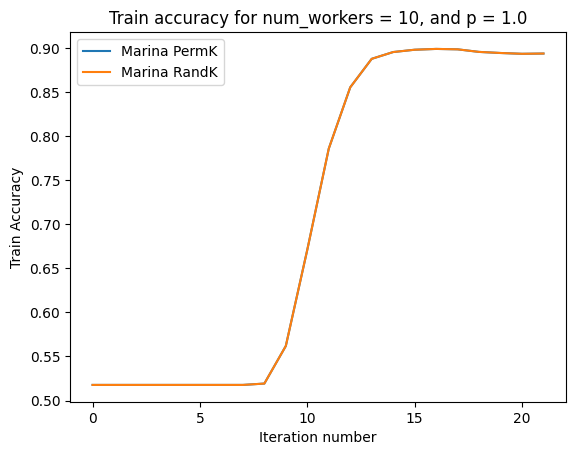

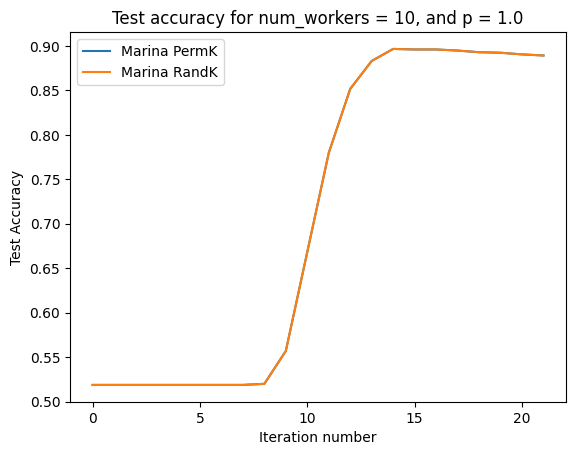

 21%|██        | 21/100 [00:31<01:57,  1.49s/it]


Marina with RandK compressor with 30 workers, took 33.46618580818176 seconds


 21%|██        | 21/100 [00:31<01:57,  1.49s/it]


Marina with PermK compressor with 30 workers, took 33.28502702713013 seconds


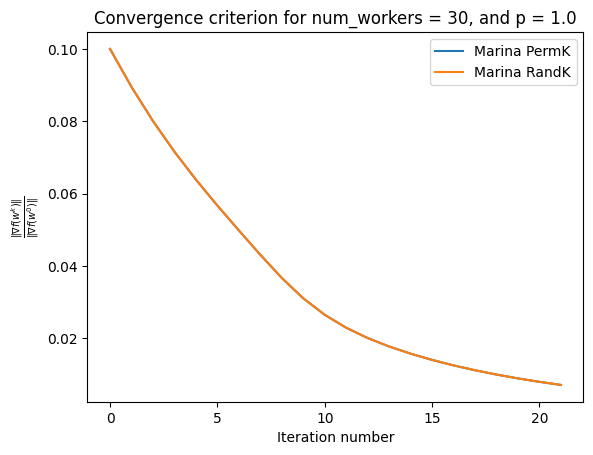

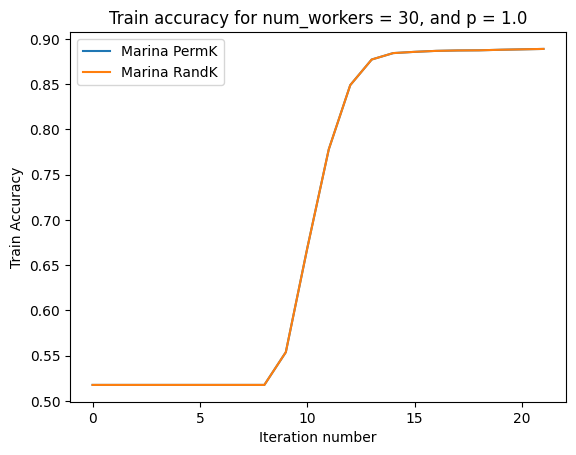

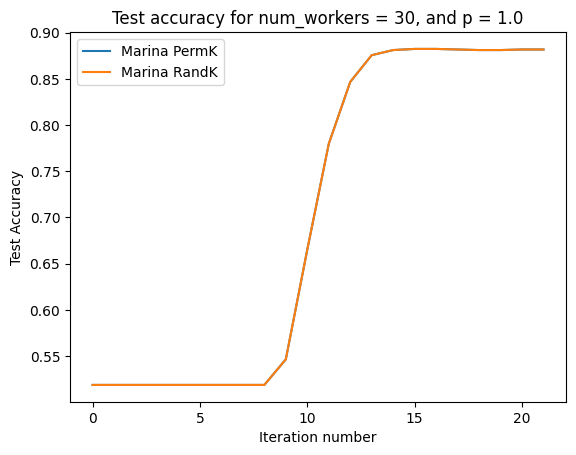

 21%|██        | 21/100 [00:32<02:04,  1.57s/it]


Marina with RandK compressor with 100 workers, took 34.272836446762085 seconds


 21%|██        | 21/100 [00:32<02:03,  1.57s/it]


Marina with PermK compressor with 100 workers, took 34.30354881286621 seconds


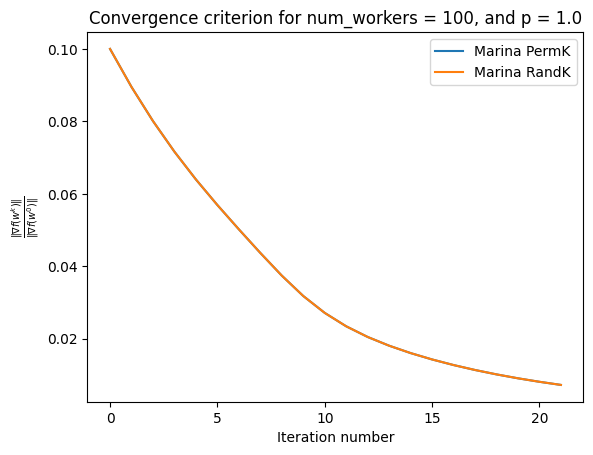

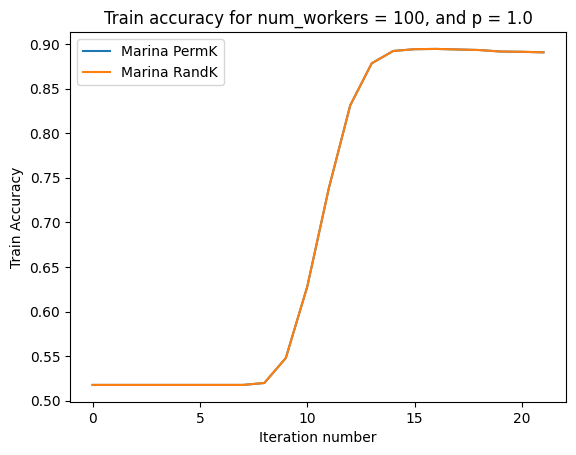

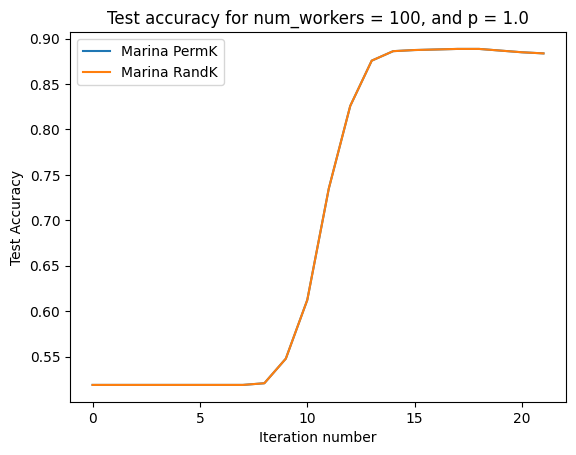

 22%|██▏       | 22/100 [00:40<02:22,  1.82s/it]


Marina with RandK compressor with 110 workers, took 41.404531955718994 seconds


 22%|██▏       | 22/100 [00:36<02:08,  1.64s/it]


Marina with PermK compressor with 110 workers, took 37.55863690376282 seconds


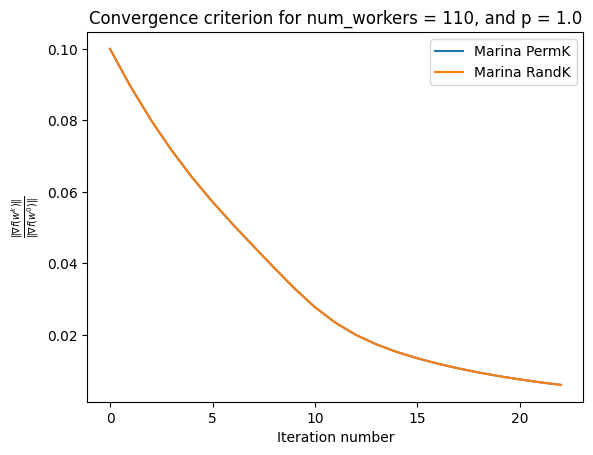

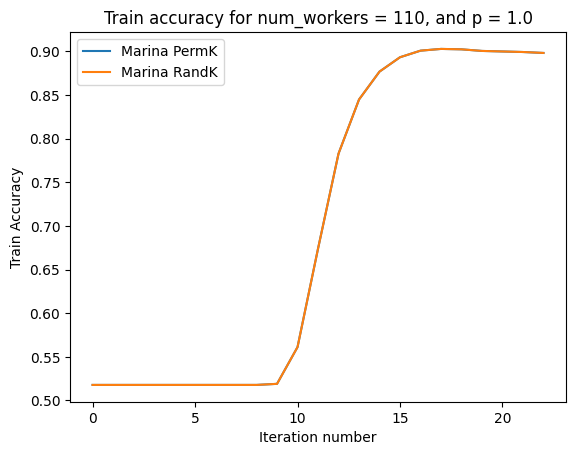

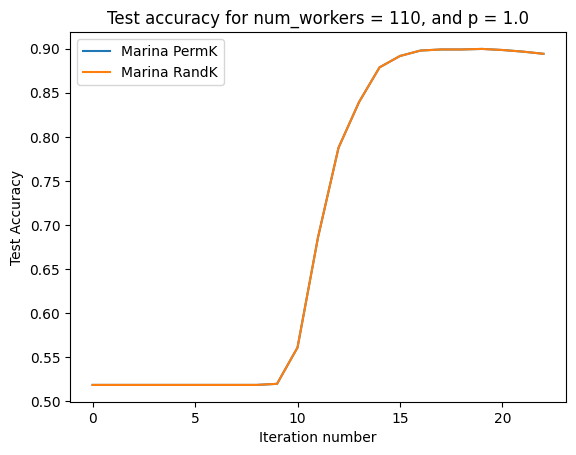

In [ ]:
def analysis(num_workers, p):
    w_0 = np.random.rand(X_train[0].shape[0])
    # num_workers = 10

    w_opt1, path1, testacc1, trainacc1 = Marina_RandK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost, k = 30,
                                                  p = p, num_workers = num_workers, iterations = 100, eps = 1e-2)

    x_cord1 = [i for i in range(len(path1))]

    w_opt, path, testacc, trainacc = Marina_PermK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                                  p = p, num_workers = num_workers, iterations = 100, eps = 1e-2)

    x_cord = [i for i in range(len(path))]
    plt.plot(x_cord, path, label = 'Marina PermK')
    plt.plot(x_cord1, path1, label = 'Marina RandK')
    plt.xlabel('Iteration number')
    plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
    plt.title(f'Convergence criterion for num_workers = {num_workers}, and p = {p}')
    plt.legend()
    plt.show()

    plt.plot(x_cord, trainacc, label = 'Marina PermK')
    plt.plot(x_cord1, trainacc1, label = 'Marina RandK')
    plt.xlabel('Iteration number')
    plt.ylabel('Train Accuracy')
    plt.title(f'Train accuracy for num_workers = {num_workers}, and p = {p}')
    plt.legend()
    plt.show()

    plt.plot(x_cord, testacc, label = 'Marina PermK')
    plt.plot(x_cord1, testacc1, label = 'Marina RandK')
    plt.xlabel('Iteration number')
    plt.ylabel('Test Accuracy')
    plt.title(f'Test accuracy for num_workers = {num_workers}, and p = {p}')
    plt.legend()
    plt.show()

ps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_workerss = [10, 30, 100, 110]
for p in ps:
    for num_workers in num_workerss:
        analysis(num_workers, p)

We observe that Marina with PermK performs better in accuracy than Marina with RandK. Also, with increase in $p$, there does not seem to be much difference between RandK and PermK

In [ ]:
def DistributedGD(w_0, data, gamma, f, num_workers = 10,
        iterations = 100, eps = 1e-8):
    '''
    Parameters
    w_0        :   Start point
    data       :   Data to train the algorithm on
    gamma      :   Learning rate
    f          :   Target function
    num_workers:   Number of independent batches to split the data into
    iterations :   Number if iterations
    eps        :   Accuracy

    Return
    w_opt   :   Optimal point found by the algorithm
    path    :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]/norm(w_0)
    testacc :   Prediction accuracy per iteration on test set
    trainacc:   Prediction accuracy per iteration on train set
    '''
    start = time.time()
    b = len(data[0])//num_workers
    batches = split_data(b, data)
    # To have the number of parts equal to the number of workers
    batches = tuple(list(batches[:num_workers]))
    obj_ref = [worker.remote(w_0, gamma, batch, f) for batch in batches]
    obj = ray.get(obj_ref)
    g = np.array(sum(obj))/num_workers
    norm_w_0 = np.linalg.norm(g)
    path = []
    testacc = []
    trainacc = []
    w_prev = w_0
    for _ in tqdm(range(iterations)):
        w_new = w_prev - gamma * g
        obj_ref = [worker.remote(w_new, gamma, batch, f) for batch in batches]
        obj = ray.get(obj_ref)
        g = np.array(sum(obj))/num_workers
        path.append(np.linalg.norm(w_new - w_prev)/norm_w_0)
        testacc.append(sum(predict(w_new, X_test) == y_test)/len(y_test))
        trainacc.append(sum(predict(w_new, X_train) == y_train)/len(y_train))
        if np.all(np.abs(w_new - w_prev) <= eps):
            break
        w_prev = w_new
    w_opt = w_new
    end = time.time()
    print(f'Distributed GD with {num_workers} workers, took {end - start} seconds')
    return w_opt, path, testacc, trainacc

 22%|██▏       | 22/100 [00:27<01:38,  1.27s/it]


Distributed GD with 10 workers, took 34.420405864715576 seconds


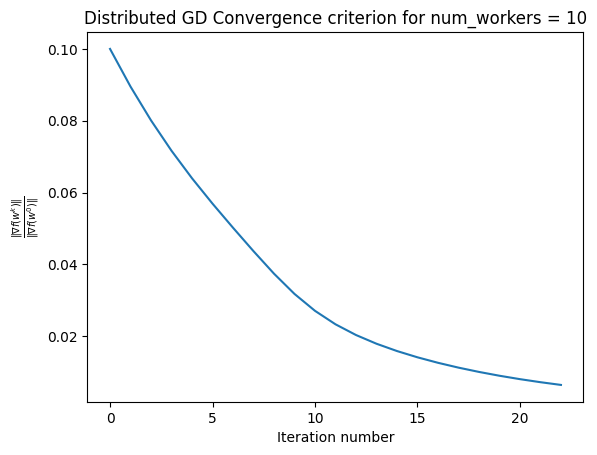

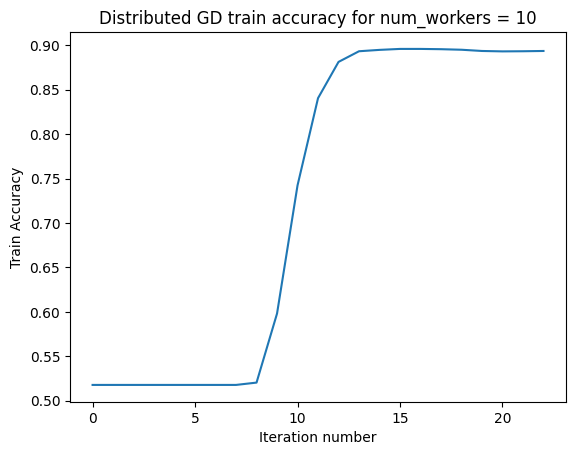

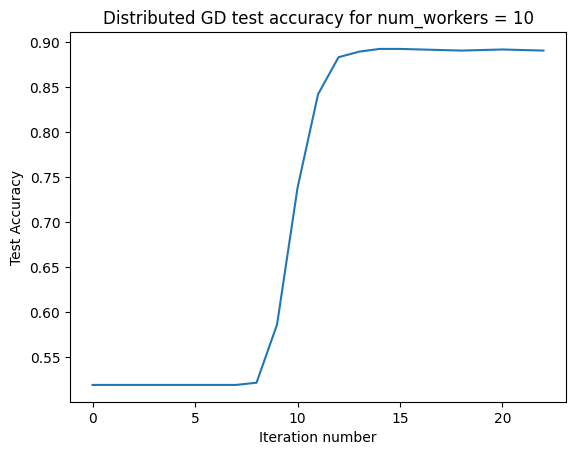

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 10
w_opt, path, testacc, trainacc = DistributedGD(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                              num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord = [i for i in range(len(path))]
plt.plot(x_cord, path)
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'Distributed GD Convergence criterion for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, trainacc)
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'Distributed GD train accuracy for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, testacc)
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'Distributed GD test accuracy for num_workers = {num_workers}')
plt.show()

In [ ]:
def CGD_RandK(w_0, data, gamma, f, k, num_workers = 10,
        iterations = 100, eps = 1e-8):
    '''
    Finds the zero of nabla_f using stochastic gradient descent with compression

    Parameters
    w_0        :   Start point
    data       :   Data to train the algorithm on
    gamma      :   Learning rate
    f          :   Target function
    k          :   Parameter for RandK compressor
    num_workers:   Number of independent batches to split the data into
    iterations :   Number if iterations
    eps        :   Accuracy

    Return
    w_opt   :   Optimal point found by the algorithm
    path    :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]/norm(w_0)
    testacc :   Prediction accuracy per iteration on test set
    trainacc:   Prediction accuracy per iteration on train set
    '''
    start = time.time()
    b = len(data[0])//num_workers
    batches = split_data(b, data)
    # To have the number of parts equal to the number of workers
    batches = tuple(list(batches[:num_workers]))
    obj_ref = [worker.remote(w_0, gamma, batch, f) for batch in batches]
    obj = ray.get(obj_ref)
    g = np.array(sum(obj))/num_workers
    norm_w_0 = np.linalg.norm(g)
    path = []
    testacc = []
    trainacc = []
    w_prev = w_0
    for _ in tqdm(range(iterations)):
        w_new = w_prev - gamma * g
        obj_ref = [worker.remote(w_new, gamma, batch, f) for batch in batches]
        obj = ray.get(obj_ref)
        g_new = np.zeros_like(w_prev)
        for i in range(num_workers):
            comp, mask = RandK(k, obj[i])
            g_new += comp
        g_new /= num_workers
        g = g_new
        path.append(np.linalg.norm(w_new - w_prev)/norm_w_0)
        testacc.append(sum(predict(w_new, X_test) == y_test)/len(y_test))
        trainacc.append(sum(predict(w_new, X_train) == y_train)/len(y_train))
        if np.all(np.abs(w_new - w_prev) <= eps):
            break
        w_prev = w_new
    w_opt = w_new
    end = time.time()
    print(f'CGD with RandK compressor with {num_workers} workers, took {end - start} seconds')
    return w_opt, path, testacc, trainacc

 27%|██▋       | 27/100 [00:42<01:56,  1.59s/it]


CGD with RandK compressor with 10 workers, took 43.962137937545776 seconds


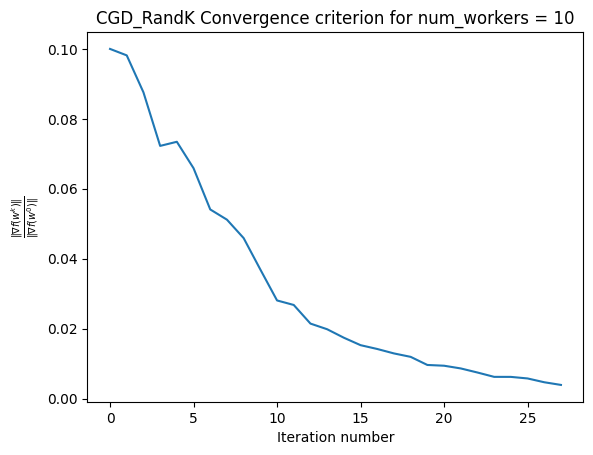

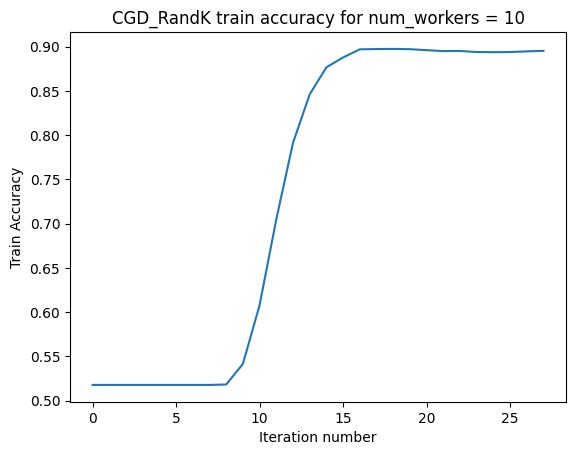

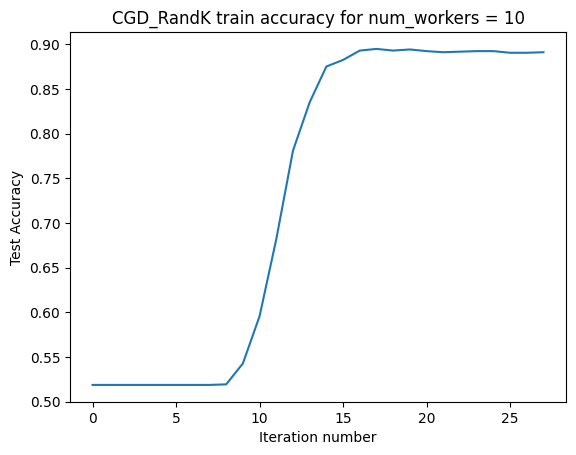

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 10
w_opt, path, testacc, trainacc = CGD_RandK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost, k = 30,
                                              num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord = [i for i in range(len(path))]
plt.plot(x_cord, path)
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'CGD_Rand30% Convergence criterion for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, trainacc)
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'CGD_RandK train accuracy for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, testacc)
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'CGD_RandK train accuracy for num_workers = {num_workers}')
plt.show()

In [ ]:
def CGD_PermK(w_0, data, gamma, f, num_workers = 10,
        iterations = 100, eps = 1e-8):
    '''
    Finds the zero of nabla_f using stochastic gradient descent with compression

    Parameters
    w_0        :   Start point
    data       :   Data to train the algorithm on
    gamma      :   Learning rate
    f          :   Target function
    num_workers:   Number of independent batches to split the data into
    iterations :   Number if iterations
    eps        :   Accuracy

    Return
    w_opt   :   Optimal point found by the algorithm
    path    :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]/norm(w_0)
    testacc :   Prediction accuracy per iteration on test set
    trainacc:   Prediction accuracy per iteration on train set
    '''
    start = time.time()
    b = len(data[0])//num_workers
    batches = split_data(b, data)
    # To have the number of parts equal to the number of workers
    batches = tuple(list(batches[:num_workers]))
    # norm_w_0 = np.linalg.norm(g)
    path = []
    testacc = []
    trainacc = []
    w_prev = w_0
    d = len(w_0)
    for _ in tqdm(range(iterations)):
        obj_ref = [worker.remote(w_prev, gamma, batch, f) for batch in batches]
        obj = ray.get(obj_ref)
        g_new = np.zeros_like(w_prev)
        cs = PermK(d, num_workers)
        for i in range(num_workers):
            comp = cs[i] * obj[i]
            g_new += comp
        g_new /= num_workers
        g = g_new
        w_new = w_prev - gamma * g
        path.append(np.linalg.norm(w_new - w_prev))
        testacc.append(sum(predict(w_new, X_test) == y_test)/len(y_test))
        trainacc.append(sum(predict(w_new, X_train) == y_train)/len(y_train))
        if np.all(np.abs(w_new - w_prev) <= eps):
            break
        w_prev = w_new
    w_opt = w_new
    path = np.array(path)/np.linalg.norm(path[0])
    end = time.time()
    print(f'CGD with PermK compressor with {num_workers} workers, took {end - start} seconds')
    return w_opt, path, testacc, trainacc

 21%|██        | 21/100 [00:34<02:08,  1.63s/it]


CGD with PermK compressor with 1 workers, took 34.23721408843994 seconds


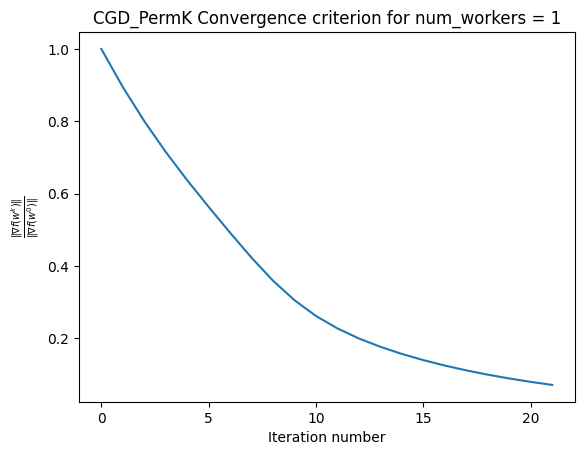

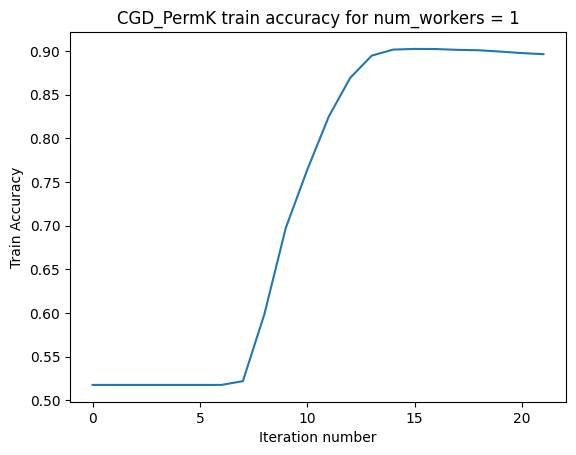

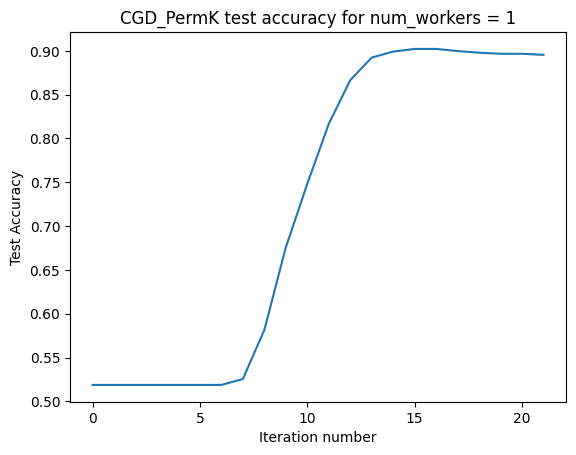

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 1
w_opt, path, testacc, trainacc = CGD_PermK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                          num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord = [i for i in range(len(path))]
plt.plot(x_cord, path)
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'CGD_PermK Convergence criterion for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, trainacc)
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'CGD_PermK train accuracy for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, testacc)
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'CGD_PermK test accuracy for num_workers = {num_workers}')
plt.show()

 21%|██        | 21/100 [00:27<01:42,  1.30s/it]


CGD with PermK compressor with 2 workers, took 27.365668773651123 seconds


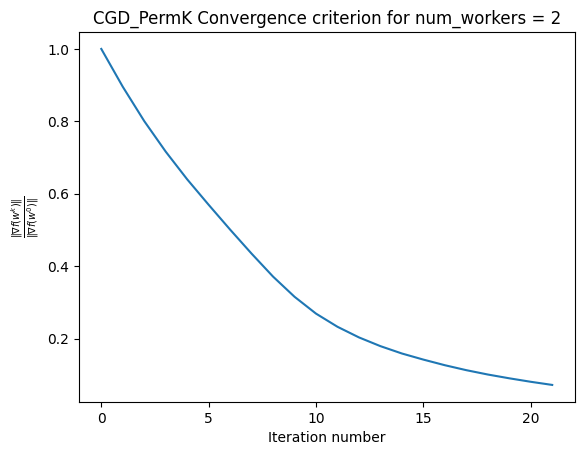

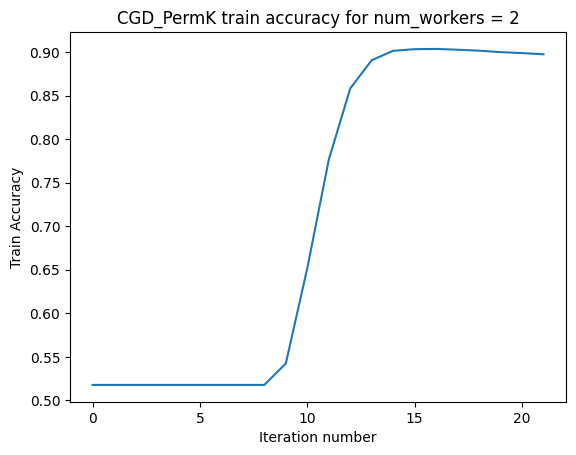

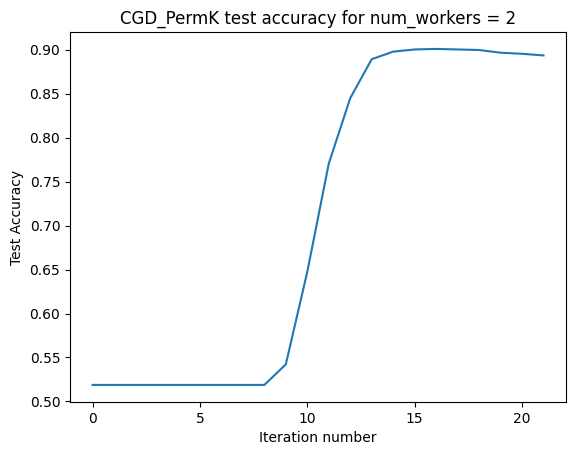

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 2
w_opt, path, testacc, trainacc = CGD_PermK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                          num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord = [i for i in range(len(path))]
plt.plot(x_cord, path)
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'CGD_PermK Convergence criterion for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, trainacc)
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'CGD_PermK train accuracy for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, testacc)
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'CGD_PermK test accuracy for num_workers = {num_workers}')
plt.show()

 25%|██▌       | 25/100 [00:34<01:43,  1.39s/it]


CGD with PermK compressor with 10 workers, took 34.64498233795166 seconds


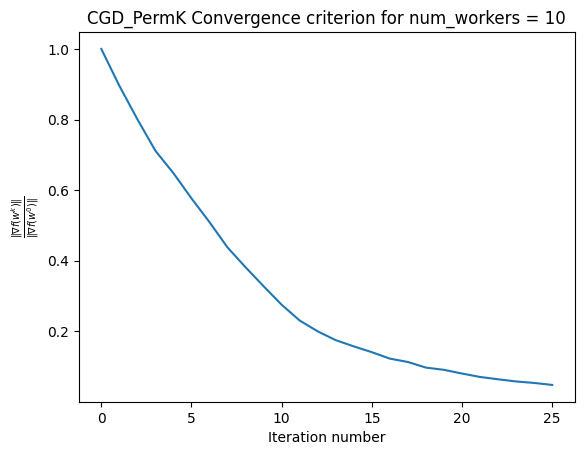

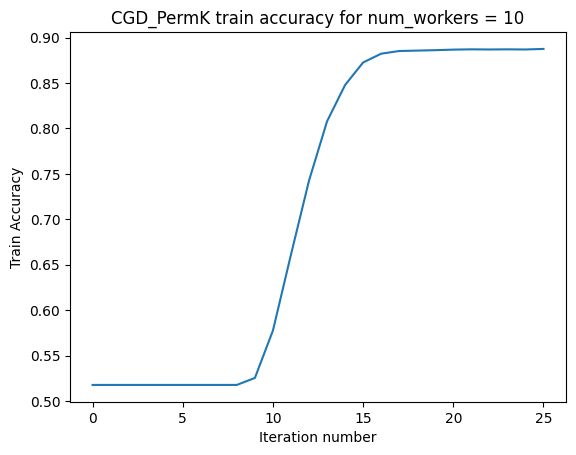

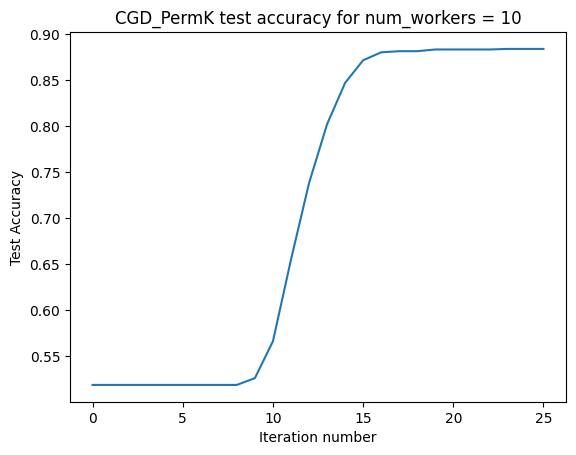

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 10
w_opt, path, testacc, trainacc = CGD_PermK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                          num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord = [i for i in range(len(path))]
plt.plot(x_cord, path)
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'CGD_PermK Convergence criterion for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, trainacc)
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'CGD_PermK train accuracy for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, testacc)
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'CGD_PermK test accuracy for num_workers = {num_workers}')
plt.show()

 21%|██        | 21/100 [00:31<01:57,  1.49s/it]


CGD with PermK compressor with 4 workers, took 31.24137282371521 seconds


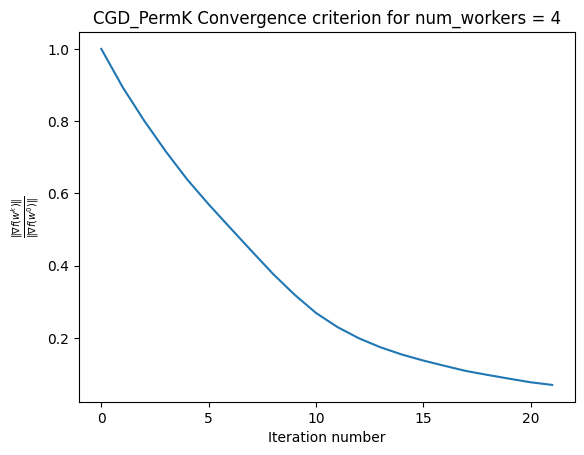

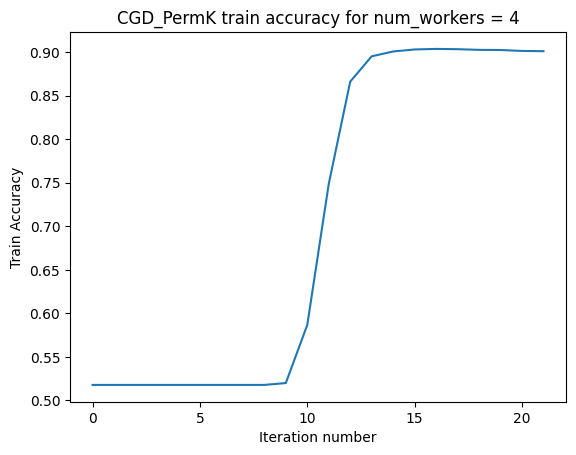

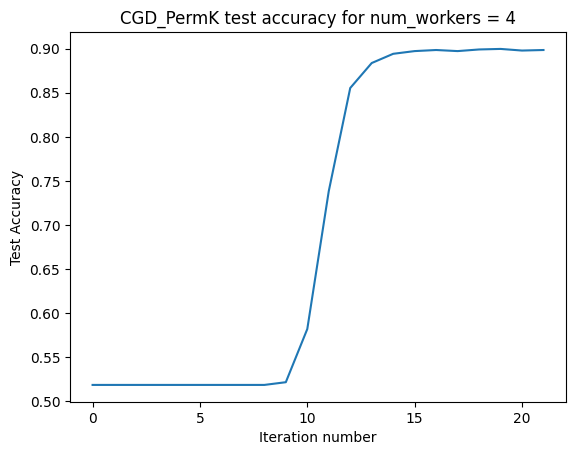

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 4
w_opt, path, testacc, trainacc = CGD_PermK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                          num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord = [i for i in range(len(path))]
plt.plot(x_cord, path)
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'CGD_PermK Convergence criterion for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, trainacc)
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'CGD_PermK train accuracy for num_workers = {num_workers}')
plt.show()

plt.plot(x_cord, testacc)
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'CGD_PermK test accuracy for num_workers = {num_workers}')
plt.show()

 26%|██▌       | 26/100 [00:32<01:32,  1.25s/it]


CGD with RandK compressor with 10 workers, took 33.46980428695679 seconds


 23%|██▎       | 23/100 [00:29<01:38,  1.28s/it]


CGD with PermK compressor with 10 workers, took 29.51031994819641 seconds


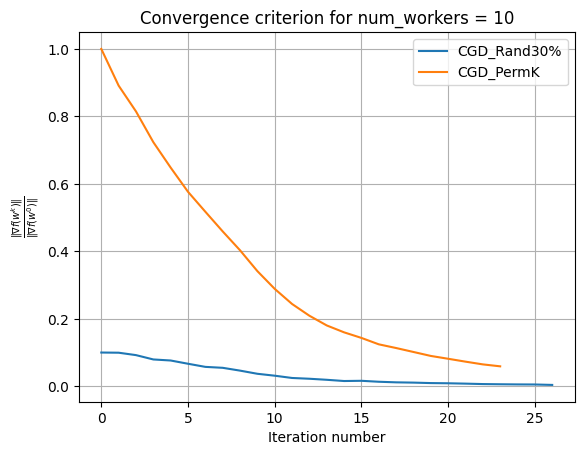

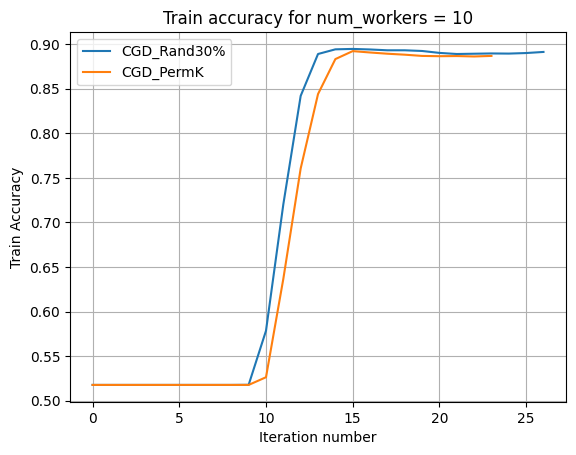

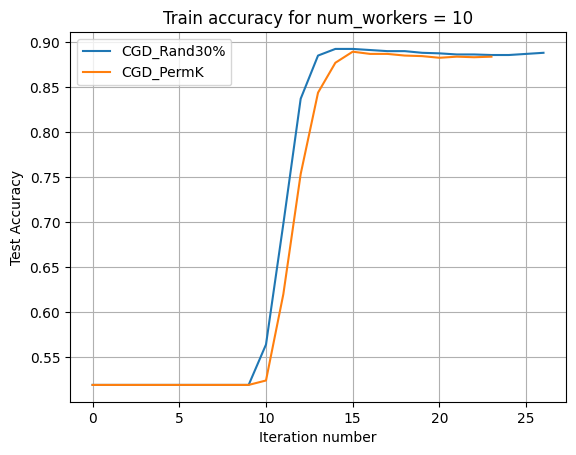

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 10
k = 30
w_opt, path, testacc, trainacc = CGD_RandK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost, k = k,
                                              num_workers = num_workers, iterations = 100, eps = 1e-2)
x_cord = [i for i in range(len(path))]

w_opt1, path1, testacc1, trainacc1 = CGD_PermK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                          num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord1 = [i for i in range(len(path1))]

plt.plot(x_cord, path, label = f'CGD_Rand{k}%')
plt.plot(x_cord1, path1, label = 'CGD_PermK')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'Convergence criterion for num_workers = {num_workers}')
plt.legend()
plt.grid()
plt.show()

plt.plot(x_cord, trainacc, label = f'CGD_Rand{k}%')
plt.plot(x_cord1, trainacc1, label = 'CGD_PermK')
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'Train accuracy for num_workers = {num_workers}')
plt.legend()
plt.grid()
plt.show()

plt.plot(x_cord, testacc, label = f'CGD_Rand{k}%')
plt.plot(x_cord1, testacc1, label = 'CGD_PermK')
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'Train accuracy for num_workers = {num_workers}')
plt.legend()
plt.grid()
plt.show()

 24%|██▍       | 24/100 [00:41<02:10,  1.72s/it]


CGD with RandK compressor with 50 workers, took 43.63445425033569 seconds


 26%|██▌       | 26/100 [00:42<02:00,  1.63s/it]


CGD with PermK compressor with 50 workers, took 42.391698122024536 seconds


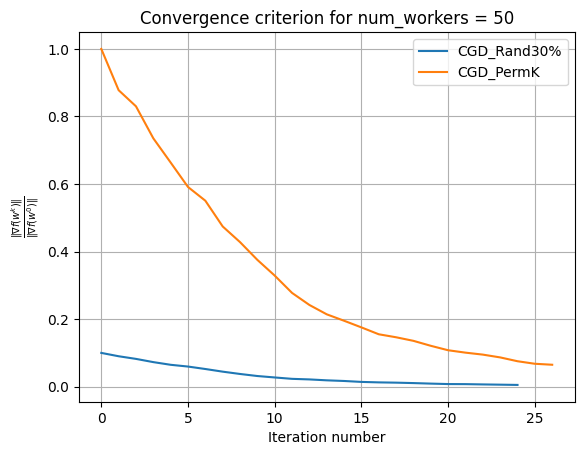

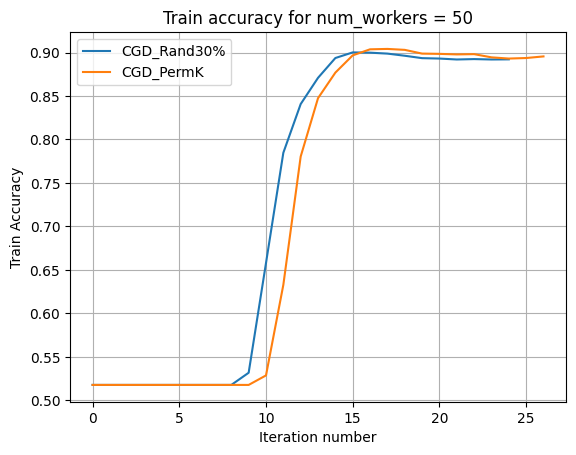

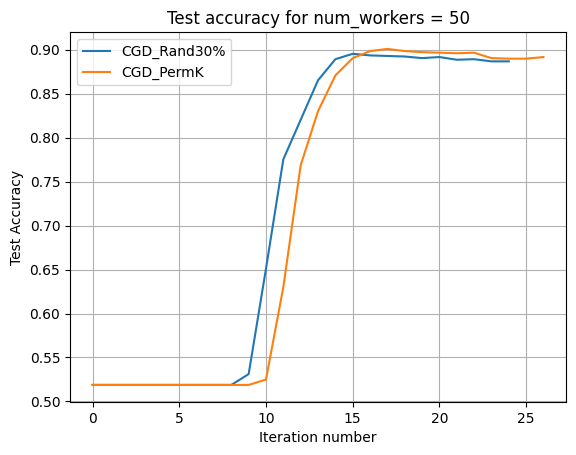

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 50
k = 30
w_opt, path, testacc, trainacc = CGD_RandK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost, k = k,
                                              num_workers = num_workers, iterations = 100, eps = 1e-2)
x_cord = [i for i in range(len(path))]

w_opt1, path1, testacc1, trainacc1 = CGD_PermK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                          num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord1 = [i for i in range(len(path1))]

plt.plot(x_cord, path, label = f'CGD_Rand{k}%')
plt.plot(x_cord1, path1, label = 'CGD_PermK')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'Convergence criterion for num_workers = {num_workers}')
plt.legend()
plt.grid()
plt.show()

plt.plot(x_cord, trainacc, label = f'CGD_Rand{k}%')
plt.plot(x_cord1, trainacc1, label = 'CGD_PermK')
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'Train accuracy for num_workers = {num_workers}')
plt.legend()
plt.grid()
plt.show()

plt.plot(x_cord, testacc, label = f'CGD_Rand{k}%')
plt.plot(x_cord1, testacc1, label = 'CGD_PermK')
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'Test accuracy for num_workers = {num_workers}')
plt.legend()
plt.grid()
plt.show()

 29%|██▉       | 29/100 [00:35<01:27,  1.23s/it]


CGD with RandK compressor with 10 workers, took 36.647868633270264 seconds


 22%|██▏       | 22/100 [00:30<01:49,  1.40s/it]


CGD with PermK compressor with 10 workers, took 30.832969427108765 seconds


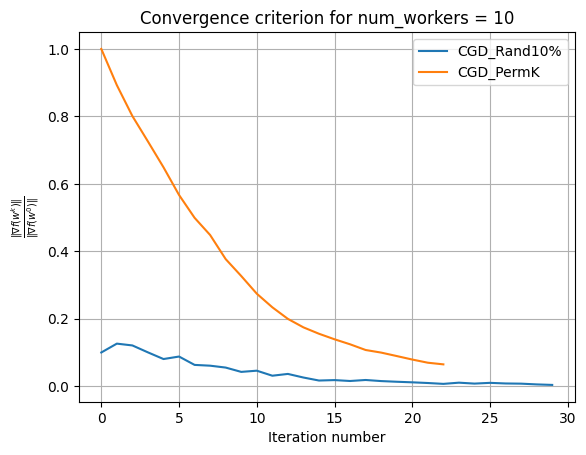

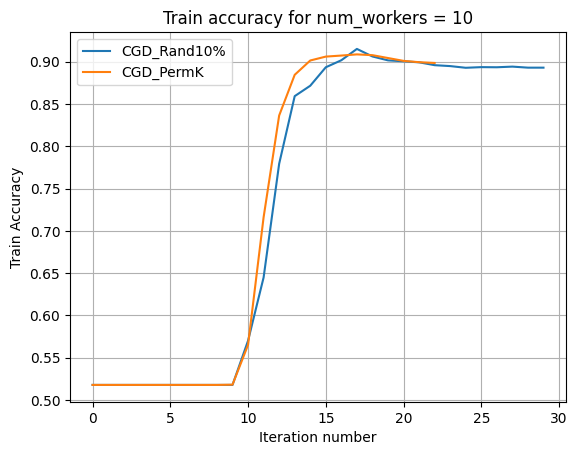

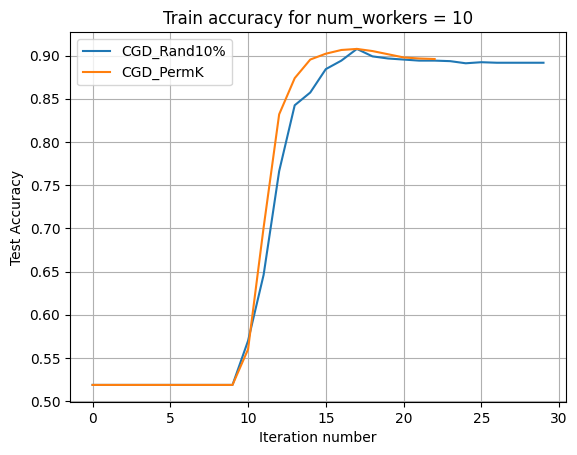

In [ ]:
w_0 = np.random.rand(X_train[0].shape[0])
num_workers = 10
k = 10
w_opt, path, testacc, trainacc = CGD_RandK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost, k = k,
                                              num_workers = num_workers, iterations = 100, eps = 1e-2)
x_cord = [i for i in range(len(path))]

w_opt1, path1, testacc1, trainacc1 = CGD_PermK(w_0, data = (X_train, y_train), gamma = 0.1, f = cost,
                                          num_workers = num_workers, iterations = 100, eps = 1e-2)

x_cord1 = [i for i in range(len(path1))]

plt.plot(x_cord, path, label = f'CGD_Rand{k}%')
plt.plot(x_cord1, path1, label = 'CGD_PermK')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.title(f'Convergence criterion for num_workers = {num_workers}')
plt.legend()
plt.grid()
plt.show()

plt.plot(x_cord, trainacc, label = f'CGD_Rand{k}%')
plt.plot(x_cord1, trainacc1, label = 'CGD_PermK')
plt.xlabel('Iteration number')
plt.ylabel('Train Accuracy')
plt.title(f'Train accuracy for num_workers = {num_workers}')
plt.legend()
plt.grid()
plt.show()

plt.plot(x_cord, testacc, label = f'CGD_Rand{k}%')
plt.plot(x_cord1, testacc1, label = 'CGD_PermK')
plt.xlabel('Iteration number')
plt.ylabel('Test Accuracy')
plt.title(f'Train accuracy for num_workers = {num_workers}')
plt.legend()
plt.grid()
plt.show()